<a href="https://colab.research.google.com/github/stanxwong/Algorithms-for-Searching-Sorting-and-Indexing/blob/main/FT_LSTM_Bitcoin_250102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
!pip install holidays
import holidays

Mounted at /content/drive/


In [ ]:
 #@title Import Data
df = pd.read_csv("/content/drive/MyDrive/Stand_Harvest/updated_raw.csv", parse_dates=['UTC'], index_col='UTC')
df2 = pd.read_csv("/content/drive/MyDrive/Stand_Harvest/premium_index.csv",   parse_dates=['UTC'], index_col='UTC')

# fillna longShortRatio
df['longShortRatio'] = df['longShortRatio'].fillna(1.0)

# Premium Range
df2['premium_range'] = df2['premium_high'] - df2['premium_low']

In [ ]:
#@title Data Transformation - Long Short Ratio
# 1
df3 = pd.concat([df, df2], axis=1)
df3.drop(['longAccount', 'shortAccount'], axis=1, inplace=True)

#2
df3['HKT'] = df3.index + pd.Timedelta(hours=8)
# Format HKT datetime without timezone offse
df3['HKT'] = df3['HKT'].dt.strftime('%Y-%m-%d %H:%M:%S')
# Insert the HKT column as the third column
df3.insert(0, 'HKT', df3.pop('HKT'))

#3
df3 = df3.sort_index(ascending=True)
df3['longShortRatio'] = df3['longShortRatio'].fillna(1.0)
df4 = df3.dropna()

In [ ]:
#@title Data Transformation - TA
# Ensure required library is installed
%%capture
# Your code goes here

!pip install ta

import ta
from datetime import timedelta
# 1. Price-Based Indicators
df4.loc[:, 'SMA_10'] = df4['Close'].rolling(window=10).mean()  # Simple Moving Average (10)
df4.loc[:, 'SMA_24'] = df4['Close'].rolling(window=24).mean()  # Simple Moving Average (24)
df4.loc[:, 'EMA_10'] = ta.trend.ema_indicator(close=df4['Close'], window=10)  # Exponential Moving Average (10)
df4.loc[:, 'EMA_24'] = ta.trend.ema_indicator(close=df4['Close'], window=24)  # Exponential Moving Average (24)

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df4['Close'], window=20)
df4.loc[:, 'Bollinger_High'] = bollinger.bollinger_hband()  # Upper Band
df4.loc[:, 'Bollinger_Low'] = bollinger.bollinger_lband()  # Lower Band
df4.loc[:, 'Bollinger_Width'] = df4['Bollinger_High'] - df4['Bollinger_Low']  # Band Width

# Average True Range (ATR)
df4.loc[:, 'ATR'] = ta.volatility.AverageTrueRange(
    high=df4['High'], low=df4['Low'], close=df4['Close'], window=14
).average_true_range()

# 2. Momentum Indicators
df4.loc[:, 'RSI'] = ta.momentum.RSIIndicator(close=df4['Close'], window=14).rsi()  # Relative Strength Index

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(
    high=df4['High'], low=df4['Low'], close=df4['Close'], window=14, smooth_window=3
)
df4.loc[:, 'Stochastic'] = stoch.stoch()

# MACD Line
df4.loc[:, 'MACD'] = ta.trend.MACD(close=df4['Close']).macd()

# 3. Volume-Based Indicators
df4.loc[:, 'OBV'] = ta.volume.OnBalanceVolumeIndicator(
    close=df4['Close'], volume=df4['Volume']
).on_balance_volume()
df4.loc[:, 'Volume_MA'] = df4['Volume'].rolling(window=10).mean()  # Moving Average of Volume

# 4. Target and Volatility Indicators
#df4.loc[:, 'Close_48h_ahead'] = df4['Close'].shift(-48)  # Shift to predict 48 hours ahead

# Calculate Percent Difference (Fixed Formula)
#df4.loc[:, 'Percent_Diff'] = ((df4['Close_48h_ahead'] / df4['Close']) - 1) * 100  # Percent difference in percentage form

# Add a new column for time + 48 hours
df4['HKT'] = pd.to_datetime(df4['HKT'])
df4['HKT_Predict_Time'] = df4['HKT'] + timedelta(hours=48)
df4[['HKT','HKT_Predict_Time']]

In [ ]:
# 從索引提取星期幾
df4['day_of_week'] = df4.index.dayofweek

# 創建美國假日集合
us_holidays = holidays.US()

# 將索引轉為日期進行匹配
df4['is_holiday'] = df4.index.map(lambda x: 1 if x.date() in us_holidays else 0)
df4

<ipython-input-5-854b32b1b10e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['day_of_week'] = df4.index.dayofweek
<ipython-input-5-854b32b1b10e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['is_holiday'] = df4.index.map(lambda x: 1 if x.date() in us_holidays else 0)


,HKT,Open,High,Low,Close,Volume,longShortRatio,premium_open,premium_high,premium_low,...,Bollinger_Width,ATR,RSI,Stochastic,MACD,OBV,Volume_MA,HKT_Predict_Time,day_of_week,is_holiday
UTC,,,,,,,,,,,,,,,,,,,,,
2021-11-17 06:00:00,2021-11-17 14:00:00,59594.04,59797.57000,59288.16,59607.990000,1239.028060,1.0000,0.000524,0.001359,-0.000162,...,NaN,0.000000,NaN,NaN,NaN,1239.028060,NaN,2021-11-19 14:00:00,2,0
2021-11-17 07:00:00,2021-11-17 15:00:00,59607.99,60142.85000,59350.00,59688.000000,1948.059450,1.0000,0.000535,0.001312,-0.000040,...,NaN,0.000000,NaN,NaN,NaN,3187.087510,NaN,2021-11-19 15:00:00,2,0
2021-11-17 08:00:00,2021-11-17 16:00:00,59691.90,60023.00000,59570.01,59586.180000,1749.517440,1.0000,0.000334,0.001367,-0.000424,...,NaN,0.000000,NaN,NaN,NaN,1437.570070,NaN,2021-11-19 16:00:00,2,0
2021-11-17 09:00:00,2021-11-17 17:00:00,59586.19,59591.93000,58800.00,58926.020000,2304.005740,1.0000,0.000596,0.001342,-0.000441,...,NaN,0.000000,NaN,NaN,NaN,-866.435670,NaN,2021-11-19 17:00:00,2,0
2021-11-17 10:00:00,2021-11-17 18:00:00,58926.02,60601.03000,58373.00,60508.030000,4350.330590,1.0000,0.000797,0.002491,-0.000647,...,NaN,0.000000,NaN,NaN,NaN,3483.894920,NaN,2021-11-19 18:00:00,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 22:00:00,2025-02-01 06:00:00,102148.72,102482.94000,101918.46,102261.300000,759.957220,1.4576,-0.000476,-0.000224,-0.000808,...,4239.328110,741.228154,34.835216,15.752471,-590.552175,545903.531027,1441.008450,2025-02-03 06:00:00,4,0
2025-01-31 23:00:00,2025-02-01 07:00:00,102261.29,102439.31000,101955.00,102429.560000,587.312390,1.4845,-0.000466,-0.000156,-0.000900,...,4415.397063,722.876857,36.819729,19.531896,-614.361722,546490.843417,1433.732929,2025-02-03 07:00:00,4,0
2025-02-01 00:00:00,2025-02-01 08:00:00,102429.56,102575.06000,102213.07,102494.940000,538.121760,1.5176,-0.000452,-0.000076,-0.001061,...,4562.960822,697.099225,37.614737,21.000449,-620.799154,547028.965177,1381.083513,2025-02-03 08:00:00,5,0


In [ ]:
#@title Capture the Most Recent 1200 Rows (Last 50 Days) of Data
#%%capture
df4 = df4.dropna()
df5 = df4.iloc[-1200:]
#df5 = df4
df5 = df5.iloc[:-1]
df5

,HKT,Open,High,Low,Close,Volume,longShortRatio,premium_open,premium_high,premium_low,...,Bollinger_Width,ATR,RSI,Stochastic,MACD,OBV,Volume_MA,HKT_Predict_Time,day_of_week,is_holiday
UTC,,,,,,,,,,,,,,,,,,,,,
2024-12-13 03:00:00,2024-12-13 11:00:00,99484.99,99793.50000,99484.98,99729.090000,532.233580,0.9231,-0.000300,-0.000007,-0.000595,...,3006.503744,728.551494,45.586103,15.714843,-149.390892,555399.213964,1051.455799,2024-12-15 11:00:00,4,0
2024-12-13 04:00:00,2024-12-13 12:00:00,99729.09,100054.91000,99652.00,100000.460000,531.664190,0.9421,-0.000358,0.000062,-0.000635,...,3005.895335,705.291387,48.167673,23.851874,-143.758783,555930.878154,1013.825326,2024-12-15 12:00:00,4,0
2024-12-13 05:00:00,2024-12-13 13:00:00,100000.46,100172.00000,99850.35,99890.000000,430.054130,0.9448,-0.000263,-0.000042,-0.000536,...,3027.526405,677.888431,47.186336,20.539730,-146.519510,555500.824024,770.580429,2024-12-15 13:00:00,4,0
2024-12-13 06:00:00,2024-12-13 14:00:00,99889.99,100092.00000,99700.00,99700.000000,483.542240,0.9279,-0.000301,0.000074,-0.000498,...,3086.329274,657.467829,45.470311,19.839679,-162.169430,555017.281784,661.832070,2024-12-15 14:00:00,4,0
2024-12-13 07:00:00,2024-12-13 15:00:00,99700.00,100225.52000,99500.00,100130.000000,1277.182610,0.9029,-0.000429,0.000000,-0.000660,...,3093.621711,662.328698,49.910050,37.712771,-138.280684,556294.464394,713.143171,2024-12-15 15:00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 21:00:00,2025-02-01 05:00:00,101680.02,102166.11000,101560.00,102148.730000,1047.574670,1.3480,-0.000310,0.000126,-0.000922,...,3962.231524,754.824166,33.538333,13.223944,-534.440757,545143.573807,1426.361558,2025-02-03 05:00:00,4,0
2025-01-31 22:00:00,2025-02-01 06:00:00,102148.72,102482.94000,101918.46,102261.300000,759.957220,1.4576,-0.000476,-0.000224,-0.000808,...,4239.328110,741.228154,34.835216,15.752471,-590.552175,545903.531027,1441.008450,2025-02-03 06:00:00,4,0
2025-01-31 23:00:00,2025-02-01 07:00:00,102261.29,102439.31000,101955.00,102429.560000,587.312390,1.4845,-0.000466,-0.000156,-0.000900,...,4415.397063,722.876857,36.819729,19.531896,-614.361722,546490.843417,1433.732929,2025-02-03 07:00:00,4,0


In [ ]:
#@title Feature Selection for Generic Model
# Select specified columns and the last 1920 rows
new_data = df5[
    [
        'Open',
        'longShortRatio',
        'Bollinger_Width',
        'ATR',
        'RSI',
        'Stochastic',
        'MACD',
        'OBV',
        'Volume_MA',
        'premium_close',
        'premium_range',
        'is_holiday',
        'day_of_week'
    ]
]

In [ ]:
#@title Import Original Model
from keras.models import load_model

# Load the saved model (replace with the path to your saved model file)
model = load_model('/content/drive/MyDrive/Colab Notebooks/BTC/250102/btc_model_250102.keras')  # Or 'lstm_model.keras' if you saved in Keras format

# Print the model summary to confirm it's loaded
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,502 (853.53 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 145,669 (569.02 KB)

None


In [ ]:
#@title Import Scaler
import joblib

# Load the saved scalers
feature_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/BTC/250102/btc_feature_scaler_250102.pkl')  # Replace with the actual file path
target_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/BTC/250102/btc_target_scaler_250102.pkl')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
#@title Create Sequence for Generic Model
def create_sequences(X, timesteps):
    X_seq = []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i + timesteps])
    return np.array(X_seq)

In [ ]:
#@title Create Sliding Window Sequences for Generic Model

new_scaled = feature_scaler.transform(new_data)

# 使用滑動窗口生成 LSTM 輸入
timesteps = 50
X_new_seq = create_sequences(new_scaled, timesteps)

# 確認輸入數據形狀
print(f"新數據的形狀: {X_new_seq.shape}")  # 應為 (samples, timesteps, features)

# 使用模型進行預測
predictions_scaled = model.predict(X_new_seq)

新數據的形狀: (1149, 50, 13)
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step


In [ ]:
#@title Use Generic Model to Make Prediction
predictions_original = target_scaler.inverse_transform(predictions_scaled)
predicted_df = pd.DataFrame(predictions_original, columns=["Predicted"])
predicted_df["Original_Index"] = new_data.index[timesteps:]  # 對應滑動窗口後的索引
predicted_df.set_index("Original_Index", inplace=True)


In [ ]:
#@title Result of Generic Model - Data Transformation
#title 轉換
from datetime import timedelta

# Ensure the index is a datetime type
predicted_df.index = pd.to_datetime(predicted_df.index)

# Step 1: Localize index to UTC and convert to HKT
predicted_df['HKT'] = predicted_df.index.tz_localize('UTC').tz_convert('Asia/Hong_Kong')

# Step 2: Add Predicted Time (HKT + 48 hours)
predicted_df['Predicted_Time'] = predicted_df['HKT'] + timedelta(hours=48)

# Step 3: Format both HKT_Time and Predicted_Time to strings without timezone
predicted_df['HKT'] = predicted_df['HKT'].dt.strftime('%Y-%m-%d %H:%M:%S')
predicted_df['Predicted_Time'] = predicted_df['Predicted_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Define the new column order
new_column_order = ['HKT', 'Predicted_Time', 'Predicted']

# Reorder the DataFrame columns
predicted_df = predicted_df[new_column_order]

# Round the Predicted column to 3 decimal places
predicted_df['Predicted'] = predicted_df['Predicted'].round(3)

# Display the DataFrame with the rearranged columns
# Combine the DataFrames using the index
result = pd.concat([df4[['Close']], predicted_df], axis=1)

#@title Result Data Transformation 3
mae_value = 0.81

# Add a new column 'MAE'
result['Upper_MAE'] = result['Predicted']+ mae_value

# Add a new column 'ME' with the condition
result['Lower_MAE'] = result['Predicted'] - mae_value

result['Pre-Price'] = result['Close'] * (1 + result['Predicted'] / 100)
result['Upper_MAE_Price'] = result['Close'] * (1 + result['Upper_MAE'] / 100)
result['Lower_MAE_Price'] = result['Close'] * (1 + result['Lower_MAE'] / 100)
result = result.dropna()
#result.iloc[-76:-25]
result

,Close,HKT,Predicted_Time,Predicted,Upper_MAE,Lower_MAE,Pre-Price,Upper_MAE_Price,Lower_MAE_Price
2024-12-15 05:00:00,102159.290000,2024-12-15 13:00:00,2024-12-17 13:00:00,2.760,3.570,1.950,104978.891509,105806.372931,104151.397909
2024-12-15 06:00:00,101759.800000,2024-12-15 14:00:00,2024-12-17 14:00:00,2.790,3.600,1.980,104598.896440,105423.154159,103774.638722
2024-12-15 07:00:00,101732.090000,2024-12-15 15:00:00,2024-12-17 15:00:00,2.622,3.432,1.812,104399.501740,105223.535007,103575.480601
2024-12-15 08:00:00,102015.150000,2024-12-15 16:00:00,2024-12-17 16:00:00,2.431,3.241,1.621,104495.137561,105321.463623,103668.811499
2024-12-15 09:00:00,102264.340000,2024-12-15 17:00:00,2024-12-17 17:00:00,2.222,3.032,1.412,104536.655223,105364.999731,103708.310714
...,...,...,...,...,...,...,...,...,...
2025-01-31 21:00:00,102148.730000,2025-02-01 05:00:00,2025-02-03 05:00:00,0.581,1.391,-0.229,102742.216405,103569.624469,101914.808341
2025-01-31 22:00:00,102261.300000,2025-02-01 06:00:00,2025-02-03 06:00:00,-0.113,0.697,-0.923,102145.746280,102974.066165,101317.426395
2025-01-31 23:00:00,102429.560000,2025-02-01 07:00:00,2025-02-03 07:00:00,-0.770,0.040,-1.580,101640.849721,102470.526412,100811.173030
2025-02-01 00:00:00,102494.940000,2025-02-01 08:00:00,2025-02-03 08:00:00,-1.269,-0.459,-2.079,101194.278423,102024.490800,100364.072156


In [ ]:
#@title Data Transformation for Incremental Model Training
%%capture
#df6 = df5.iloc[-1200:]
df6 = df5
# 4. Target and Volatility Indicators
df6.loc[:, 'Close_48h_ahead'] = df6['Close'].shift(-48)  # Shift to predict 48 hours ahead

# Calculate Percent Difference (Fixed Formula)
df6.loc[:, 'Percent_Diff'] = ((df6['Close_48h_ahead'] / df6['Close']) - 1) * 100  # Percent difference in percentage form
df6 = df6.dropna()
#df6 = df6.iloc[:-1]  # Drop the last row due the record is not compelete

In [ ]:
#@title Feature Selection for Incremental Model Training
ft_new_data = df6[[
    'Open', 'longShortRatio', 'Bollinger_Width', 'ATR', 'RSI',
    'Stochastic', 'MACD', 'OBV', 'Volume_MA', 'premium_close', 'premium_range', 'is_holiday',
    'day_of_week'
]]

ft_new_target = df6['Percent_Diff']

In [ ]:
#@title  Scale the new features and target
X_new_scaled = feature_scaler.transform(ft_new_data)
y_new_scaled = target_scaler.transform(ft_new_target.values.reshape(-1, 1))

# 2. Reshape data for LSTM (create sliding windows)
timesteps = 50  # Use the same timesteps from training
X_new_lstm = []
y_new_lstm = []

In [ ]:
#@title Create Sliding Window Sequences for LSTM Input and Targets
for i in range(len(X_new_scaled) - timesteps):
    X_new_lstm.append(X_new_scaled[i:i+timesteps])  # Create input sequences
    y_new_lstm.append(y_new_scaled[i+timesteps])   # Corresponding targets

X_new_lstm = np.array(X_new_lstm)  # Shape: (samples, timesteps, features)
y_new_lstm = np.array(y_new_lstm)  # Shape: (samples, 1)
print(f"New data shape for LSTM: {X_new_lstm.shape}, {y_new_lstm.shape}")

New data shape for LSTM: (1101, 50, 13), (1101, 1)


In [ ]:
#@title Incremental Model Training (fine-tuning)
model.fit(X_new_lstm, y_new_lstm, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0026 - mae: 0.0379
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.7171e-04 - mae: 0.0217
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.9692e-04 - mae: 0.0154
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 2.7943e-04 - mae: 0.0129
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.5743e-04 - mae: 0.0125
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 2.6604e-04 - mae: 0.0125
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 2.3621e-04 - mae: 0.0119
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.0810e-04 - mae: 0.0108
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 2.0232e-04 - mae: 0.0108
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.8129e-04 - mae: 0.0103
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.7792e-04 - mae: 0.0102
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.8398e-04 - mae:

In [ ]:
#@title Fine-Tune Modle Saving
model.save(('/content/drive/MyDrive/Colab Notebooks/BTC/250102/ft_btc_model_250102.keras'))
print("Model updated and saved.")

Model updated and saved.


In [ ]:
#@title Load the saved Fine-Tune model
ft_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTC/250102/ft_btc_model_250102.keras')  # Or 'lstm_model.keras' if you saved in Keras format

# Print the model summary to confirm it's loaded
print(ft_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,502 (853.53 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 145,669 (569.02 KB)

None


In [ ]:
#@title Generate and Inverse Transform LSTM Predictions for Visualization
ft_predictions_scaled = ft_model.predict(X_new_seq)

ft_predictions_original = target_scaler.inverse_transform(ft_predictions_scaled)

ft_predicted_df = pd.DataFrame(ft_predictions_original, columns=["Predicted"])
ft_predicted_df["Original_Index"] = new_data.index[timesteps:]  # 對應滑動窗口後的索引
ft_predicted_df.set_index("Original_Index", inplace=True)



36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [ ]:
#@title Data Transformation for the predict result

ft_predicted_df.index = pd.to_datetime(ft_predicted_df.index)

# Step 1: Localize index to UTC and convert to HKT
ft_predicted_df['HKT'] = ft_predicted_df.index.tz_localize('UTC').tz_convert('Asia/Hong_Kong')

# Step 2: Add Predicted Time (HKT + 48 hours)
ft_predicted_df['Predicted_Time'] = ft_predicted_df['HKT'] + timedelta(hours=48)

# Step 3: Format both HKT_Time and Predicted_Time to strings without timezone
ft_predicted_df['HKT'] = ft_predicted_df['HKT'].dt.strftime('%Y-%m-%d %H:%M:%S')
ft_predicted_df['Predicted_Time'] = ft_predicted_df['Predicted_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
#@title Data Transformation for 48 Hour Prediction Code Ploting
# Define the new column order
#new_column_order = ['HKT', 'Predicted_Time', 'Predicted']

# Reorder the DataFrame columns
ft_predicted_df = ft_predicted_df[new_column_order]

# Round the Predicted column to 3 decimal places
ft_predicted_df['Predicted'] = ft_predicted_df['Predicted'].round(3)

# Display the DataFrame with the rearranged columns
# Combine the DataFrames using the index
ft_result = pd.concat([df4[['Close']], ft_predicted_df], axis=1)

#@title Result Data Transformation 2
# Add a new column 'MAE'
ft_result['MAE'] = ft_result['Predicted'].apply(lambda x: x - mae_value if x > 0 else x + mae_value)

# Define the ME value
me_value = 0.09

# Add a new column 'ME' with the condition
ft_result['ME'] = ft_result['Predicted'].apply(lambda x: x - me_value if x > 0 else x + me_value)

ft_result['Pre-Price'] = ft_result['Close'] * (1 + ft_result['Predicted'] / 100)
ft_result['MAE-Price'] = ft_result['Close'] * (1 + ft_result['MAE'] / 100)
ft_result['ME-Price'] = ft_result['Close'] * (1 + ft_result['ME'] / 100)
ft_result = ft_result.dropna()
#result.iloc[-76:-25]
ft_48hr = ft_result.iloc[-48:]
ft_48hr

#ft_result.to_csv("/content/drive/MyDrive/Colab Notebooks/BTC/241217/ft_result", index=False)  # Set index=False to avoid saving the DataFrame index as a column



,Close,HKT,Predicted_Time,Predicted,MAE,ME,Pre-Price,MAE-Price,ME-Price
2025-01-30 02:00:00,104663.190000,2025-01-30 10:00:00,2025-02-01 10:00:00,-0.802,8.000014e-03,-0.712,103823.792915,104671.563070,103917.988102
2025-01-30 03:00:00,105196.000000,2025-01-30 11:00:00,2025-02-01 11:00:00,-0.060,7.500000e-01,0.030,105132.884467,105984.970001,105227.558801
2025-01-30 04:00:00,105478.000000,2025-01-30 12:00:00,2025-02-01 12:00:00,1.028,2.180000e-01,0.938,106562.315220,105707.942037,106467.383637
2025-01-30 05:00:00,105375.700000,2025-01-30 13:00:00,2025-02-01 13:00:00,2.354,1.544000e+00,2.264,107856.246084,107002.700904,107761.405944
2025-01-30 06:00:00,105184.370000,2025-01-30 14:00:00,2025-02-01 14:00:00,3.399,2.589000e+00,3.309,108759.589421,107907.593265,108664.920729
2025-01-30 07:00:00,105132.070000,2025-01-30 15:00:00,2025-02-01 15:00:00,4.068,3.258000e+00,3.978,109408.847954,108557.272672,109314.223576
2025-01-30 08:00:00,105060.010000,2025-01-30 16:00:00,2025-02-01 16:00:00,4.310,3.500000e+00,4.220,109588.096371,108737.110290,109493.542362
2025-01-30 09:00:00,105412.050000,2025-01-30 17:00:00,2025-02-01 17:00:00,4.476,3.666000e+00,4.386,110130.292176,109276.455576,110035.422336
2025-01-30 10:00:00,105345.400000,2025-01-30 18:00:00,2025-02-01 18:00:00,4.582,3.772000e+00,4.492,110172.325995,109319.028255,110077.515135
2025-01-30 11:00:00,105300.630000,2025-01-30 19:00:00,2025-02-01 19:00:00,4.571,3.761000e+00,4.481,110113.918387,109260.986799,110019.151335


In [ ]:
# Define the window size
window_size = 48

# Add column for mean of Pre-Price in the previous 48 rows
ft_result['Mean_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).mean()

# Add column for mean of Close in the previous 48 rows
ft_result['Mean_Close_48'] = ft_result['Close'].rolling(window=window_size).mean()

# Add column for peak (maximum) of Pre-Price in the previous 48 rows
ft_result['Peak_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).max()

# Add column for dip (minimum) of Pre-Price in the previous 48 rows
ft_result['Dip_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).min()

# Add column for Mean Dip Price
ft_result['Mean_Dip_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).apply(lambda x: x[x == x.min()].mean(), raw=False)

# Add column for Mean Peak Price
ft_result['Mean_Peak_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).apply(lambda x: x[x == x.max()].mean(), raw=False)

# Add column for R-squared of Pre-Price in the previous 48 rows
def calculate_r_squared(series):
    if len(series) < window_size:
        return np.nan
    x = np.arange(len(series))
    y = series.values
    coeffs = np.polyfit(x, y, 1)
    slope, intercept = coeffs
    p = np.poly1d(coeffs)
    residuals = y - p(x)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    # Return signed R-squared based on the trend (slope)
    return r_squared * np.sign(slope)

ft_result['R_Squared_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).apply(calculate_r_squared, raw=False)

# Define a function to calculate the upper mean
def upper_mean(series):
    overall_mean = series.mean()
    return series[series > overall_mean].mean()

# Define a function to calculate the lower mean
def lower_mean(series):
    overall_mean = series.mean()
    return series[series <= overall_mean].mean()

# Apply rolling calculations for upper and lower means
ft_result['Upper_Mean_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).apply(upper_mean, raw=False)
ft_result['Lower_Mean_Pre-Price_48'] = ft_result['Pre-Price'].rolling(window=window_size).apply(lower_mean, raw=False)

def assign_trade_signal(row):
    if row['R_Squared_Pre-Price_48'] > 0.60:
        return 'Long'
    elif  row['R_Squared_Pre-Price_48'] < -0.60:
        return 'Short'
    else:
        return 'Neutral'

# Apply the function to assign trade signals
ft_result['Trade_Signal'] = ft_result.apply(assign_trade_signal, axis=1)

# Extract the relevant columns for the trade signal
trade_signal = ft_result[['HKT', 'Close', 'Predicted_Time', 'R_Squared_Pre-Price_48',
                          'Mean_Pre-Price_48', 'Upper_Mean_Pre-Price_48',
                          'Lower_Mean_Pre-Price_48', 'Mean_Dip_Pre-Price_48',
                          'Mean_Peak_Pre-Price_48', 'Trade_Signal']]

# Display the last 96 rows of the trade signal DataFrame
trade_signal.tail(96)

,HKT,Close,Predicted_Time,R_Squared_Pre-Price_48,Mean_Pre-Price_48,Upper_Mean_Pre-Price_48,Lower_Mean_Pre-Price_48,Mean_Dip_Pre-Price_48,Mean_Peak_Pre-Price_48,Trade_Signal
2025-01-28 02:00:00,2025-01-28 10:00:00,102402.010000,2025-01-30 10:00:00,0.120274,102586.779567,103207.469727,101853.236650,100530.657520,104955.917551,Neutral
2025-01-28 03:00:00,2025-01-28 11:00:00,102636.320000,2025-01-30 11:00:00,0.168280,102633.217835,103350.477342,101915.958328,100530.657520,104955.917551,Neutral
2025-01-28 04:00:00,2025-01-28 12:00:00,102901.450000,2025-01-30 12:00:00,0.223707,102681.623432,103561.174609,101997.528071,100530.657520,105036.659798,Neutral
2025-01-28 05:00:00,2025-01-28 13:00:00,103014.590000,2025-01-30 13:00:00,0.281068,102733.967476,103729.150131,102023.122722,100530.657520,105229.402801,Neutral
2025-01-28 06:00:00,2025-01-28 14:00:00,102744.380000,2025-01-30 14:00:00,0.331652,102782.116557,103787.691327,102000.002847,100530.657520,105229.402801,Neutral
...,...,...,...,...,...,...,...,...,...,...
2025-01-31 21:00:00,2025-02-01 05:00:00,102148.730000,2025-02-03 05:00:00,-0.044893,107090.825670,109360.369650,104172.840554,101844.468124,110556.708650,Neutral
2025-01-31 22:00:00,2025-02-01 06:00:00,102261.300000,2025-02-03 06:00:00,-0.116696,107110.971529,109360.369650,104218.888230,102345.290177,110556.708650,Neutral
2025-01-31 23:00:00,2025-02-01 07:00:00,102429.560000,2025-02-03 07:00:00,-0.219712,107109.910327,109360.369650,104216.462628,102294.352524,110556.708650,Neutral
2025-02-01 00:00:00,2025-02-01 08:00:00,102494.940000,2025-02-03 08:00:00,-0.345646,107088.266619,109360.369650,104166.991295,101787.723633,110556.708650,Neutral


In [ ]:
# Ensure Predicted_Time is in datetime format
trade_signal['HKT'] = pd.to_datetime(trade_signal['HKT'], errors='coerce')
trade_signal['Predicted_Time'] = pd.to_datetime(trade_signal['Predicted_Time'], errors='coerce')

# Set the timezone to Hong Kong Time (HKT)
trade_signal['HKT'] = trade_signal['HKT'].dt.tz_localize('UTC').dt.tz_convert('Asia/Hong_Kong')
trade_signal['Predicted_Time'] = trade_signal['Predicted_Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Hong_Kong')
# Sort by Predicted_Time to ensure proper sequence
trade_signal = trade_signal.sort_values(by='HKT')

<ipython-input-25-5783b7986d91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_signal['HKT'] = pd.to_datetime(trade_signal['HKT'], errors='coerce')
<ipython-input-25-5783b7986d91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_signal['Predicted_Time'] = pd.to_datetime(trade_signal['Predicted_Time'], errors='coerce')
<ipython-input-25-5783b7986d91>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

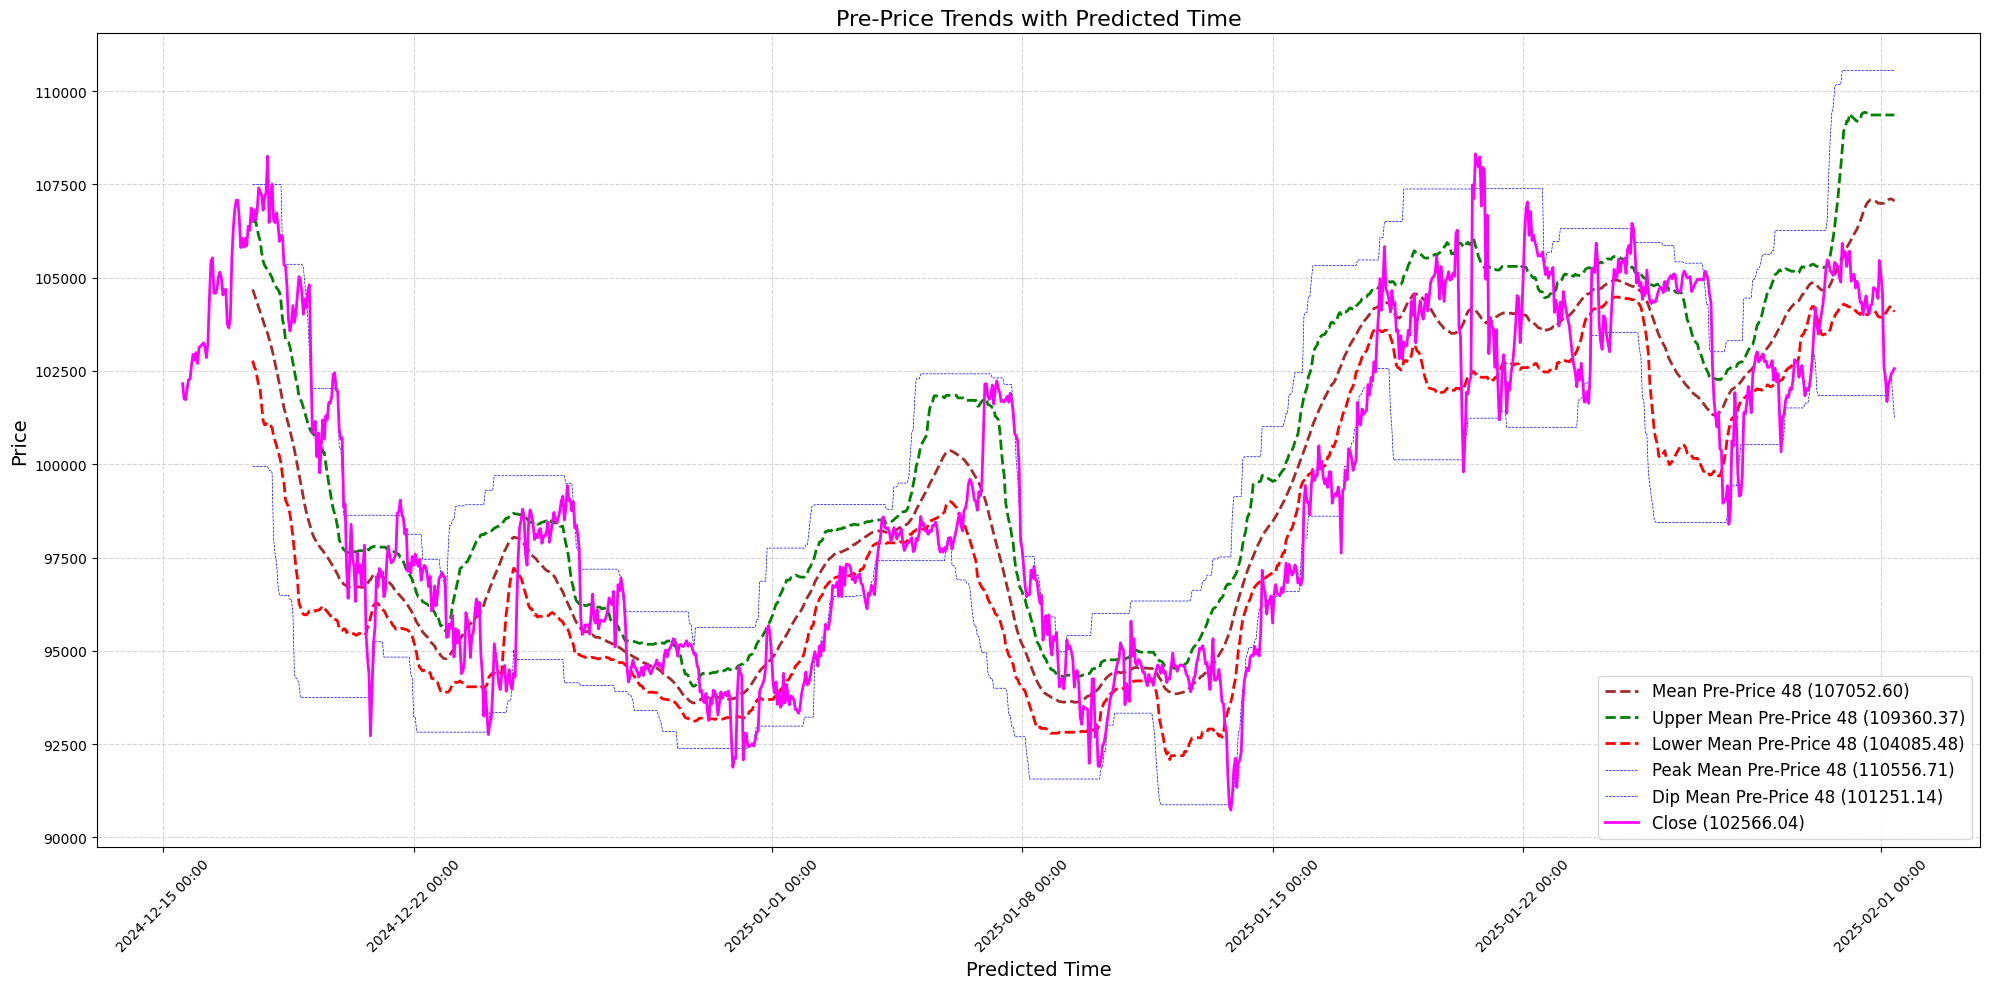

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Extract the necessary columns for plotting
x = trade_signal['HKT']
mean_price = trade_signal['Mean_Pre-Price_48']
upper_mean_price = trade_signal['Upper_Mean_Pre-Price_48']
lower_mean_price = trade_signal['Lower_Mean_Pre-Price_48']
peak_mean_price = trade_signal['Mean_Peak_Pre-Price_48']
dip_mean_price = trade_signal['Mean_Dip_Pre-Price_48']
Close = trade_signal['Close']

# Plotting
plt.figure(figsize=(20, 10))

# Plot each line with last value in legend
plt.plot(x, mean_price, label=f"Mean Pre-Price 48 ({mean_price.iloc[-1]:.2f})", color="brown", linestyle="--", linewidth=2)
plt.plot(x, upper_mean_price, label=f"Upper Mean Pre-Price 48 ({upper_mean_price.iloc[-1]:.2f})", color="green", linestyle="--", linewidth=2)
plt.plot(x, lower_mean_price, label=f"Lower Mean Pre-Price 48 ({lower_mean_price.iloc[-1]:.2f})", color="red", linestyle="--", linewidth=2)
plt.plot(x, peak_mean_price, label=f"Peak Mean Pre-Price 48 ({peak_mean_price.iloc[-1]:.2f})", color="blue", linestyle="--", linewidth=0.5)
plt.plot(x, dip_mean_price, label=f"Dip Mean Pre-Price 48 ({dip_mean_price.iloc[-1]:.2f})", color="blue", linestyle="--", linewidth=0.5)
plt.plot(x, Close, label=f"Close ({Close.iloc[-1]:.2f})", color="magenta", linestyle="-", linewidth=2)

# Format the X-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Adjust format as needed
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space labels
plt.xticks(rotation=45)

# Add title and labels
plt.title("Pre-Price Trends with Predicted Time", fontsize=16)
plt.xlabel("Predicted Time", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Add legend and grid
plt.legend(fontsize=12, loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('Trade_Signal_Trends_with_Annotations_in_Legend.jpg', format='jpg')
plt.show()

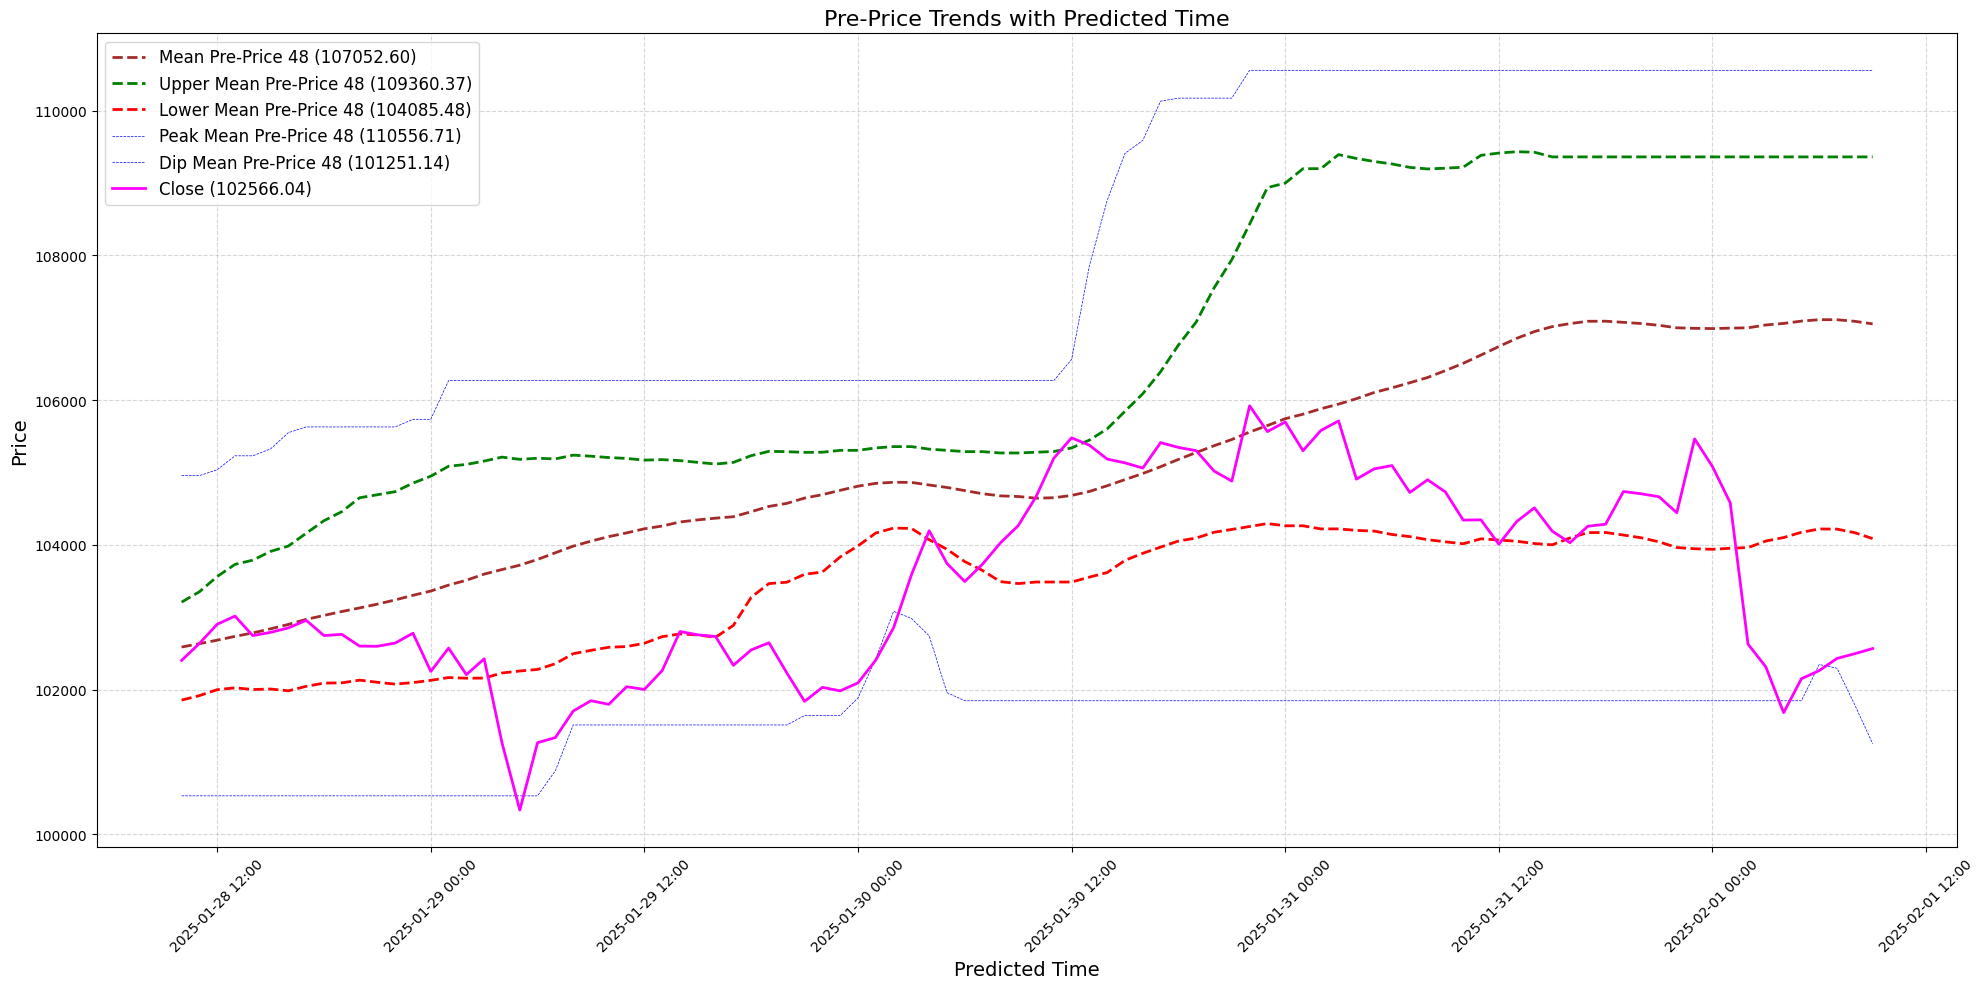

In [ ]:
trade_signal_96 = trade_signal.iloc[-96:]
# Extract the necessary columns for plotting
x = trade_signal_96['HKT']
mean_price = trade_signal_96['Mean_Pre-Price_48']
upper_mean_price = trade_signal_96['Upper_Mean_Pre-Price_48']
lower_mean_price = trade_signal_96['Lower_Mean_Pre-Price_48']
peak_mean_price = trade_signal_96['Mean_Peak_Pre-Price_48']
dip_mean_price = trade_signal_96['Mean_Dip_Pre-Price_48']
Close = trade_signal_96['Close']

# Plotting
plt.figure(figsize=(20, 10))

# Plot each line with last value in legend
plt.plot(x, mean_price, label=f"Mean Pre-Price 48 ({mean_price.iloc[-1]:.2f})", color="brown", linestyle="--", linewidth=2)
plt.plot(x, upper_mean_price, label=f"Upper Mean Pre-Price 48 ({upper_mean_price.iloc[-1]:.2f})", color="green", linestyle="--", linewidth=2)
plt.plot(x, lower_mean_price, label=f"Lower Mean Pre-Price 48 ({lower_mean_price.iloc[-1]:.2f})", color="red", linestyle="--", linewidth=2)
plt.plot(x, peak_mean_price, label=f"Peak Mean Pre-Price 48 ({peak_mean_price.iloc[-1]:.2f})", color="blue", linestyle="--", linewidth=0.5)
plt.plot(x, dip_mean_price, label=f"Dip Mean Pre-Price 48 ({dip_mean_price.iloc[-1]:.2f})", color="blue", linestyle="--", linewidth=0.5)
plt.plot(x, Close, label=f"Close ({Close.iloc[-1]:.2f})", color="magenta", linestyle="-", linewidth=2)

# Format the X-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Adjust format as needed
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space labels
plt.xticks(rotation=45)

# Add title and labels
plt.title("Pre-Price Trends with Predicted Time", fontsize=16)
plt.xlabel("Predicted Time", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Add legend and grid
plt.legend(fontsize=12, loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('Trade_Signal_Trends_with_Annotations_in_Legend.jpg', format='jpg')
plt.show()

In [ ]:
#@title Data Transformation for Swing Trade Tunnel
from scipy.stats import linregress

tunnel48h = ft_result.iloc[-96:]
tunnel = ft_result.iloc[-336:]
tunnel1w = ft_result.iloc[-168:]

mae = 0.81

tunnel48h['Upper_MAE_Price'] = tunnel48h['Close'] * (1 + result['Upper_MAE'] / 100)
tunnel48h['Lower_MAE_Price'] = tunnel48h['Close'] * (1 + result['Lower_MAE'] / 100)

tunnel['Upper_MAE_Price'] = tunnel['Close'] * (1 + result['Upper_MAE'] / 100)
tunnel['Lower_MAE_Price'] = tunnel['Close'] * (1 + result['Lower_MAE'] / 100)

tunnel1w['Upper_MAE_Price'] = tunnel1w['Close'] * (1 + result['Upper_MAE'] / 100)
tunnel1w['Lower_MAE_Price'] = tunnel1w['Close'] * (1 + result['Lower_MAE'] / 100)

<ipython-input-28-c3f584d8c400>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tunnel48h['Upper_MAE_Price'] = tunnel48h['Close'] * (1 + result['Upper_MAE'] / 100)
<ipython-input-28-c3f584d8c400>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tunnel48h['Lower_MAE_Price'] = tunnel48h['Close'] * (1 + result['Lower_MAE'] / 100)
<ipython-input-28-c3f584d8c400>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

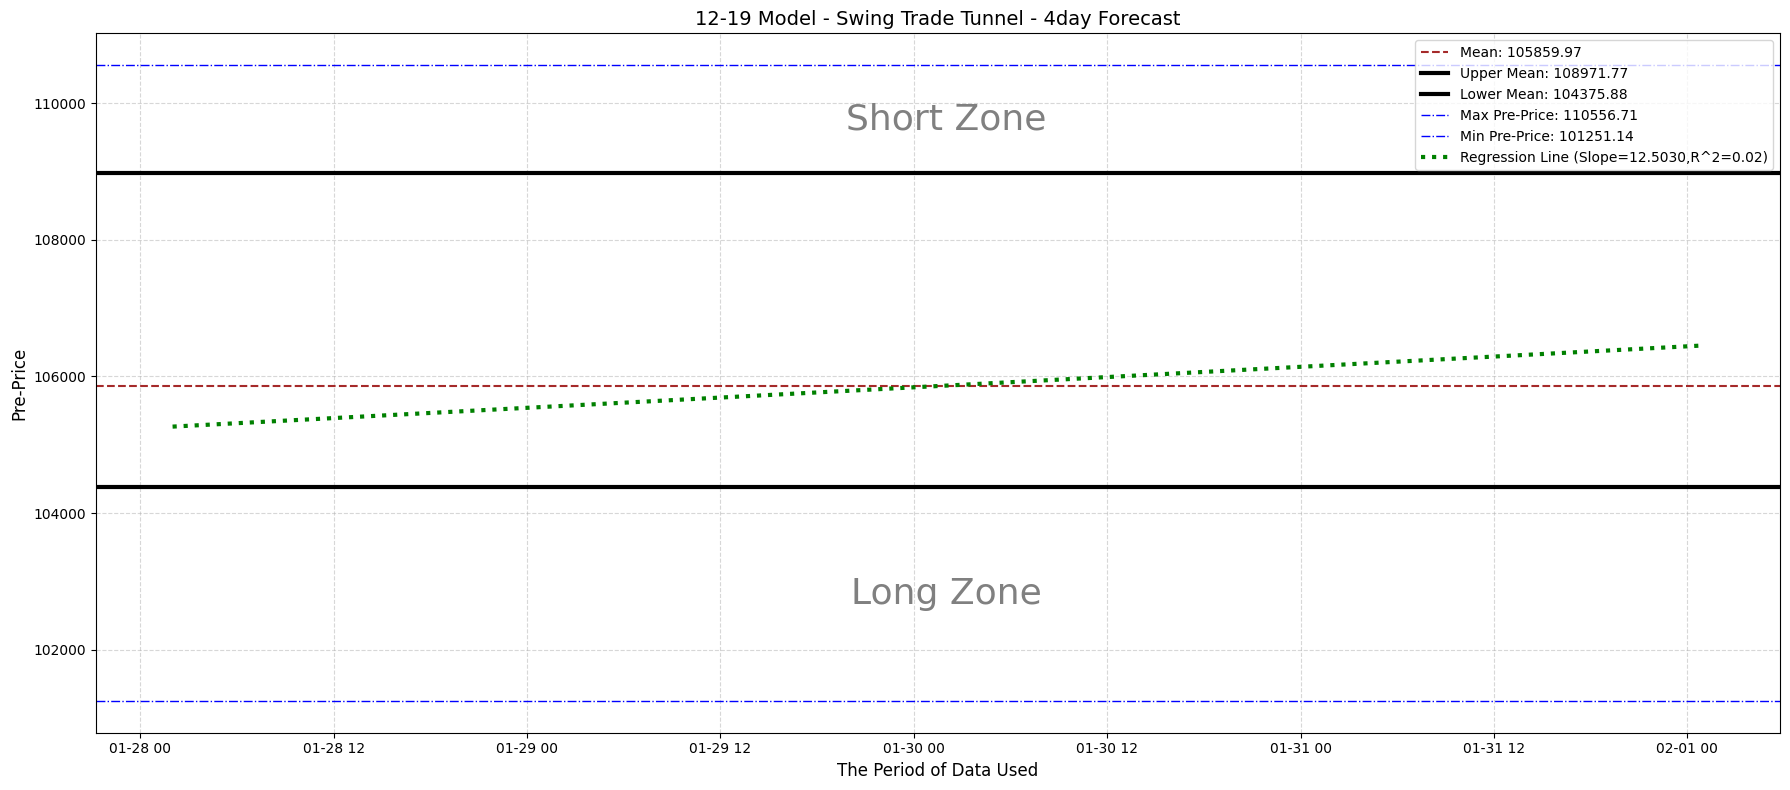

In [ ]:
#x = tunnel48h['Predicted_Time']
y = tunnel48h['Pre-Price']
#@title Swing Trade Tunnel Past 48 hours + Future 48 hours
# Calculate max and min Pre-Price

max_pre_price = tunnel48h["Pre-Price"].max()
min_pre_price = tunnel48h["Pre-Price"].min()


mean_pre_price = tunnel48h["Pre-Price"].mean()
upper_mean_pre_price = tunnel48h.loc[tunnel48h["Pre-Price"] > mean_pre_price, "Pre-Price"].mean()
lower_mean_pre_price = tunnel48h.loc[tunnel48h["Pre-Price"] < mean_pre_price, "Pre-Price"].mean()


mean_upper_mae_price = tunnel48h['Upper_MAE_Price'].mean()
upper_upper_mean_pre_price = tunnel48h.loc[tunnel["Upper_MAE_Price"] > mean_pre_price, "Upper_MAE_Price"].mean()

mean_lower_mae_price = tunnel48h['Lower_MAE_Price'].mean()
lower_lower_mean_pre_price = tunnel48h.loc[tunnel48h["Lower_MAE_Price"] < mean_pre_price, "Lower_MAE_Price"].mean()

# Calculate regression line
x = range(len(tunnel48h))
slope, intercept, r_value, _, _ = linregress(x, tunnel48h["Pre-Price"])
regression_line = [slope * i + intercept for i in x]
r_squared = r_value ** 2



# Plotting
plt.figure(figsize=(18, 8))


# Plot mean, upper mean, and lower mean
plt.axhline(mean_pre_price, color="brown", linestyle="--", linewidth=1.5, label=f"Mean: {mean_pre_price:.2f}")
plt.axhline(upper_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Upper Mean: {upper_mean_pre_price:.2f}")
plt.axhline(lower_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Lower Mean: {lower_mean_pre_price:.2f}")
plt.axhline(max_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Max Pre-Price: {max_pre_price:.2f}")
plt.axhline(min_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Min Pre-Price: {min_pre_price:.2f}")

#plt.axhline(upper_upper_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Short Price Ref: {upper_upper_mean_pre_price :.2f}")
#plt.axhline(lower_lower_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Long Price Ref: {lower_lower_mean_pre_price :.2f}")

# Plot regression line
plt.plot(tunnel48h.index, regression_line, color="green", linestyle=":", linewidth=3, label=f"Regression Line (Slope={slope:.4f},R^2={r_squared:.2f})")



# Add annotations for zones in grey color
plt.text(tunnel48h.index[len(tunnel48h)//2], (max_pre_price + upper_mean_pre_price) / 2, "Short Zone", fontsize=26, color="grey",
         ha="center", va="center")
plt.text(tunnel48h.index[len(tunnel48h)//2], (min_pre_price + lower_mean_pre_price) / 2, "Long Zone", fontsize=26, color="grey",
         ha="center", va="center")

# Add title and labels
plt.title("12-19 Model - Swing Trade Tunnel - 4day Forecast", fontsize=14)
plt.xlabel("The Period of Data Used", fontsize=12)
plt.ylabel("Pre-Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.tight_layout()
plt.savefig('Swing Trade Tunnel.jpg', format='jpg')
plt.show()

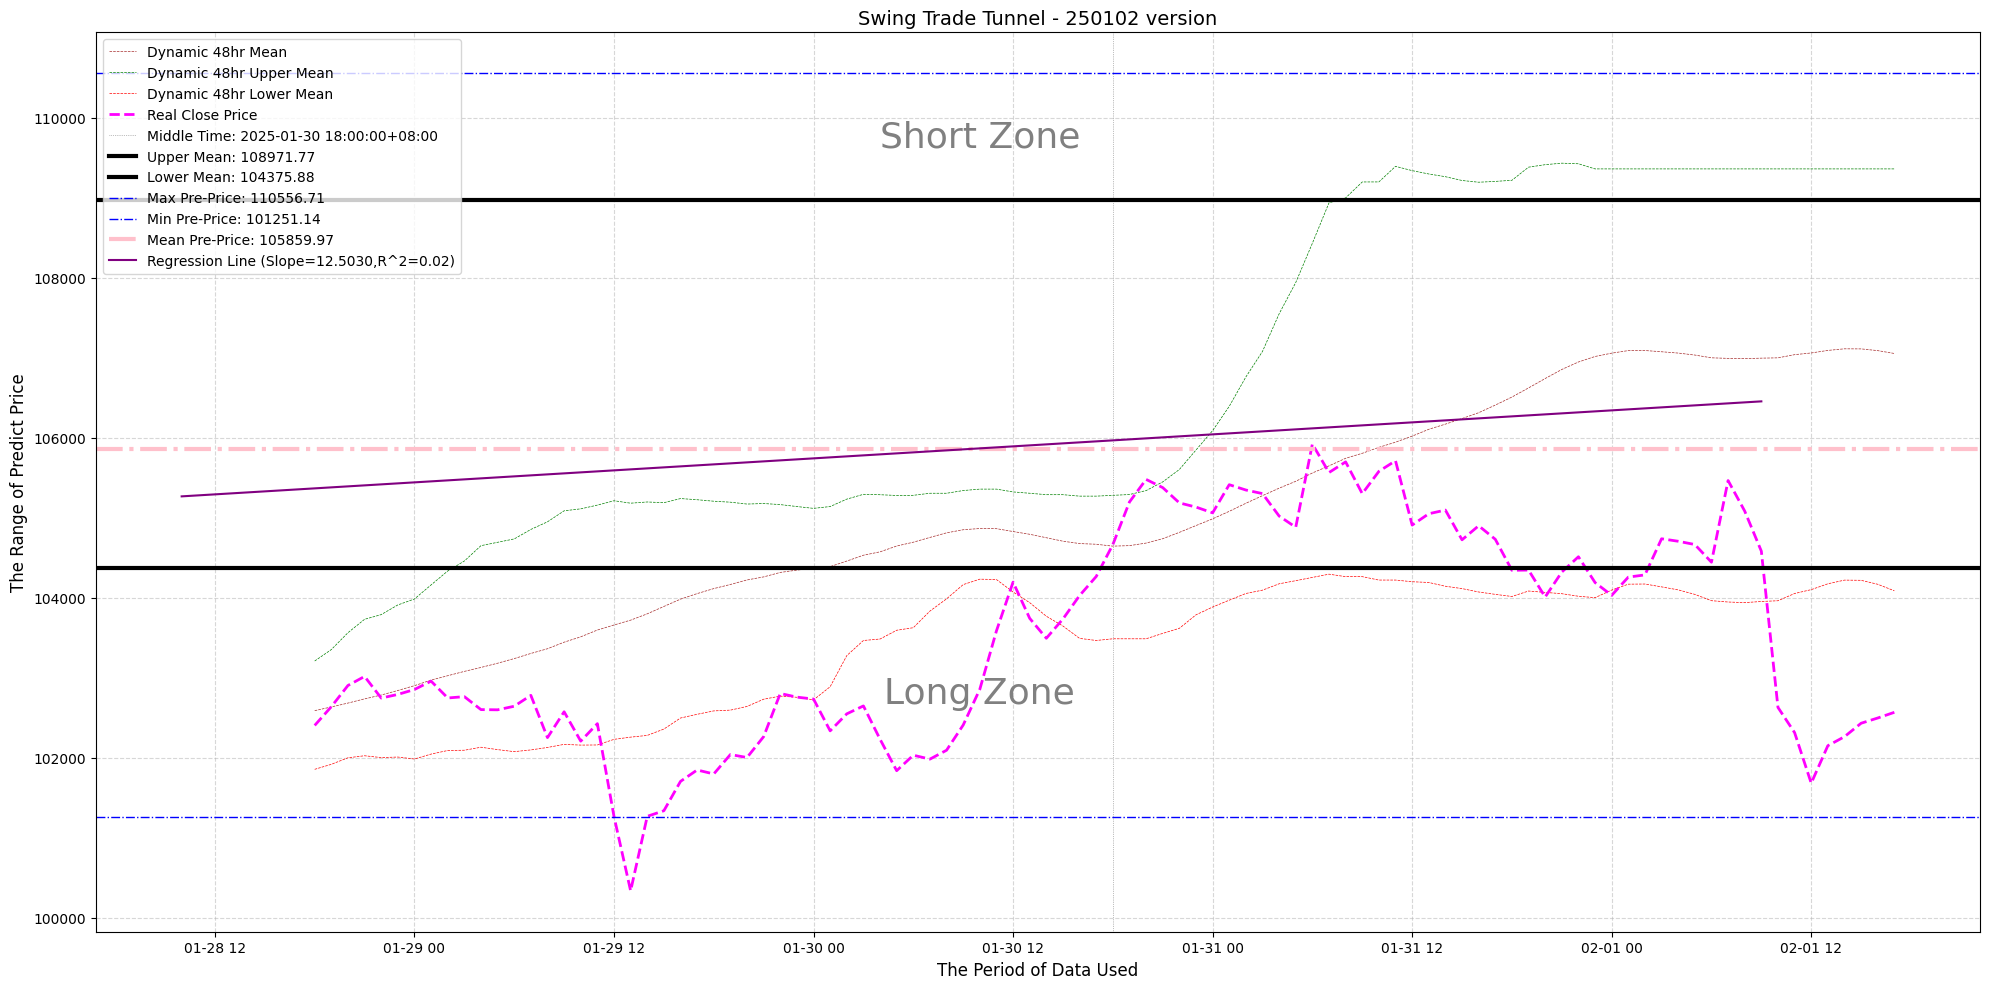

In [ ]:
#Qtitle Combined Graph
# DataFrame 1
x1 = trade_signal_96['HKT']
y1 = trade_signal_96['Mean_Pre-Price_48']
y1_upper = trade_signal_96['Upper_Mean_Pre-Price_48']
y1_lower = trade_signal_96['Lower_Mean_Pre-Price_48']
y1_close = trade_signal_96['Close']
middle_row = len(trade_signal_96) // 2
middle_time = trade_signal_96['HKT'].iloc[middle_row]


# DataFrame 2
x2 = tunnel48h['HKT']
y2 = tunnel48h["Pre-Price"].mean()
y2_upper = tunnel48h.loc[tunnel48h["Pre-Price"] > mean_pre_price, "Pre-Price"].mean()
y2_lower = tunnel48h.loc[tunnel48h["Pre-Price"] < mean_pre_price, "Pre-Price"].mean()
y2_max = tunnel48h["Pre-Price"].max()
y2_min = tunnel48h["Pre-Price"].min()

# Calculate regression linei
x2 = range(len(tunnel48h))
slope, intercept, r_value, _, _ = linregress(x2, tunnel48h["Pre-Price"])
regression_line = [slope * i + intercept for i in x2]
r_squared = r_value ** 2

# Plotting
plt.figure(figsize=(20, 10))

# Plot data from DataFrame 1
plt.plot(x1, y1, label="Dynamic 48hr Mean ", color="brown", linestyle="--", linewidth=0.5)
plt.plot(x1, y1_upper, label="Dynamic 48hr Upper Mean", color="green", linestyle="--", linewidth=0.5)
plt.plot(x1, y1_lower, label="Dynamic 48hr Lower Mean", color="red", linestyle="--", linewidth=0.5)
plt.plot(x1, y1_close, label="Real Close Price", color="magenta", linestyle="--", linewidth=2 )

# Add a vertical line at the middle time
plt.axvline(x=middle_time, color='grey', linestyle='dotted', linewidth=0.5,label=f'Middle Time: {middle_time}')

# Plot mean, upper mean, and lower mean
plt.axhline(y2_upper, color="black", linestyle="-", linewidth=3, label=f"Upper Mean: {upper_mean_pre_price:.2f}")
plt.axhline(y2_lower, color="black", linestyle="-", linewidth=3, label=f"Lower Mean: {lower_mean_pre_price:.2f}")
plt.axhline(y2_max, color="blue", linestyle="-.", linewidth=1, label=f"Max Pre-Price: {max_pre_price:.2f}")
plt.axhline(y2_min, color="blue", linestyle="-.", linewidth=1, label=f"Min Pre-Price: {min_pre_price:.2f}")
plt.axhline(y2, color="Pink", linestyle="-.", linewidth=3, label=f"Mean Pre-Price: {mean_pre_price:.2f}")

# Plot regression line
plt.plot(tunnel48h.index, regression_line, color="purple", linestyle="-", linewidth=1.5, label=f"Regression Line (Slope={slope:.4f},R^2={r_squared:.2f})")


# Add annotations for zones in grey color
plt.text(tunnel48h.index[len(tunnel48h)//2], (max_pre_price + upper_mean_pre_price) / 2, "Short Zone", fontsize=26, color="grey",
         ha="center", va="center")
plt.text(tunnel48h.index[len(tunnel48h)//2], (min_pre_price + lower_mean_pre_price) / 2, "Long Zone", fontsize=26, color="grey",
         ha="center", va="center")

plt.title("Swing Trade Tunnel - 250102 version", fontsize=14)
plt.xlabel("The Period of Data Used", fontsize=12)
plt.ylabel("The Range of Predict Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)


plt.tight_layout()
plt.savefig('Swing Trade Tunnel Final.jpg', format='jpg')
plt.show()

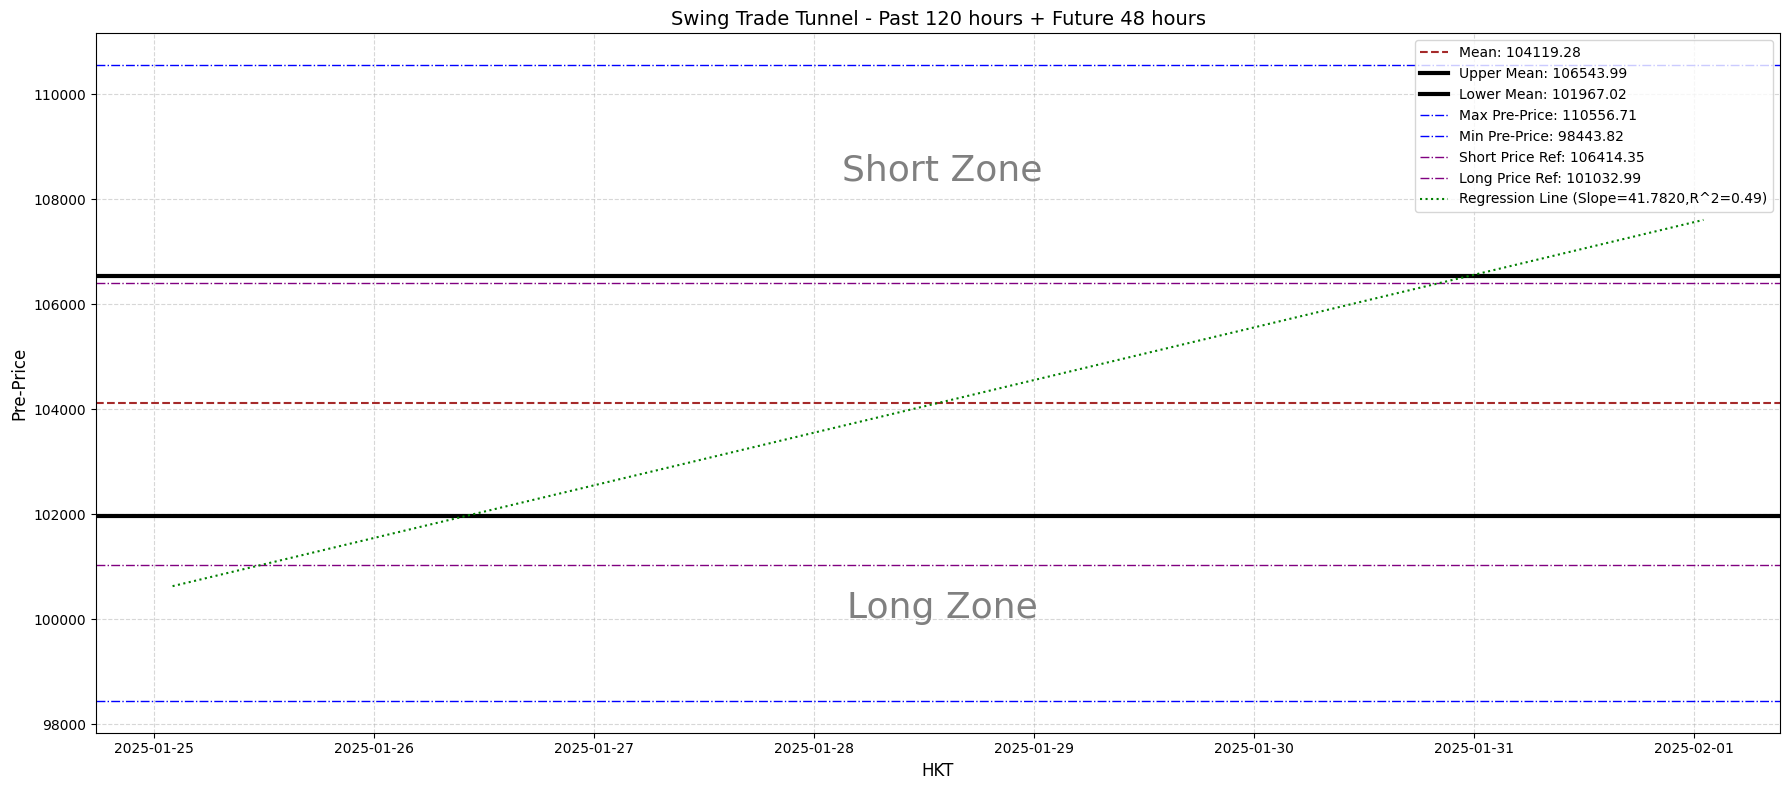

In [ ]:
x = tunnel1w['Predicted_Time']
y = tunnel1w['Pre-Price']

#@title Swing Trade Tunnel - Past 120 hours + Future 48 hours (1 Week)
# Calculate max and min Pre-Price

max_pre_price = tunnel1w["Pre-Price"].max()
min_pre_price = tunnel1w["Pre-Price"].min()


mean_pre_price = tunnel1w["Pre-Price"].mean()
upper_mean_pre_price = tunnel1w.loc[tunnel1w["Pre-Price"] > mean_pre_price, "Pre-Price"].mean()
lower_mean_pre_price = tunnel1w.loc[tunnel1w["Pre-Price"] < mean_pre_price, "Pre-Price"].mean()


mean_upper_mae_price = tunnel1w['Upper_MAE_Price'].mean()
upper_upper_mean_pre_price = tunnel1w.loc[tunnel1w["Upper_MAE_Price"] > mean_pre_price, "Upper_MAE_Price"].mean()

mean_lower_mae_price = tunnel1w['Lower_MAE_Price'].mean()
lower_lower_mean_pre_price = tunnel1w.loc[tunnel1w["Lower_MAE_Price"] < mean_pre_price, "Lower_MAE_Price"].mean()

# Calculate regression line
x = range(len(tunnel1w))
slope, intercept, r_value, _, _ = linregress(x, tunnel1w["Pre-Price"])
regression_line = [slope * i + intercept for i in x]
r_squared = r_value ** 2
# Plotting
plt.figure(figsize=(18, 8))


# Plot mean, upper mean, and lower mean
plt.axhline(mean_pre_price, color="brown", linestyle="--", linewidth=1.5, label=f"Mean: {mean_pre_price:.2f}")
plt.axhline(upper_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Upper Mean: {upper_mean_pre_price:.2f}")
plt.axhline(lower_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Lower Mean: {lower_mean_pre_price:.2f}")
plt.axhline(max_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Max Pre-Price: {max_pre_price:.2f}")
plt.axhline(min_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Min Pre-Price: {min_pre_price:.2f}")

plt.axhline(upper_upper_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Short Price Ref: {upper_upper_mean_pre_price :.2f}")
plt.axhline(lower_lower_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Long Price Ref: {lower_lower_mean_pre_price :.2f}")

# Plot regression line
plt.plot(tunnel1w.index, regression_line, color="green", linestyle=":", linewidth=1.5, label=f"Regression Line (Slope={slope:.4f},R^2={r_squared:.2f})")


# Add annotations for zones in grey color
plt.text(tunnel1w.index[len(tunnel1w)//2], (max_pre_price + upper_mean_pre_price) / 2, "Short Zone", fontsize=26, color="grey",
         ha="center", va="center")
plt.text(tunnel1w.index[len(tunnel1w)//2], (min_pre_price + lower_mean_pre_price) / 2, "Long Zone", fontsize=26, color="grey",
         ha="center", va="center")

# Add title and labels
plt.title("Swing Trade Tunnel - Past 120 hours + Future 48 hours", fontsize=14)
plt.xlabel("HKT", fontsize=12)
plt.ylabel("Pre-Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.tight_layout()
plt.savefig('Swing Trade Tunnel.jpg', format='jpg')
plt.show()

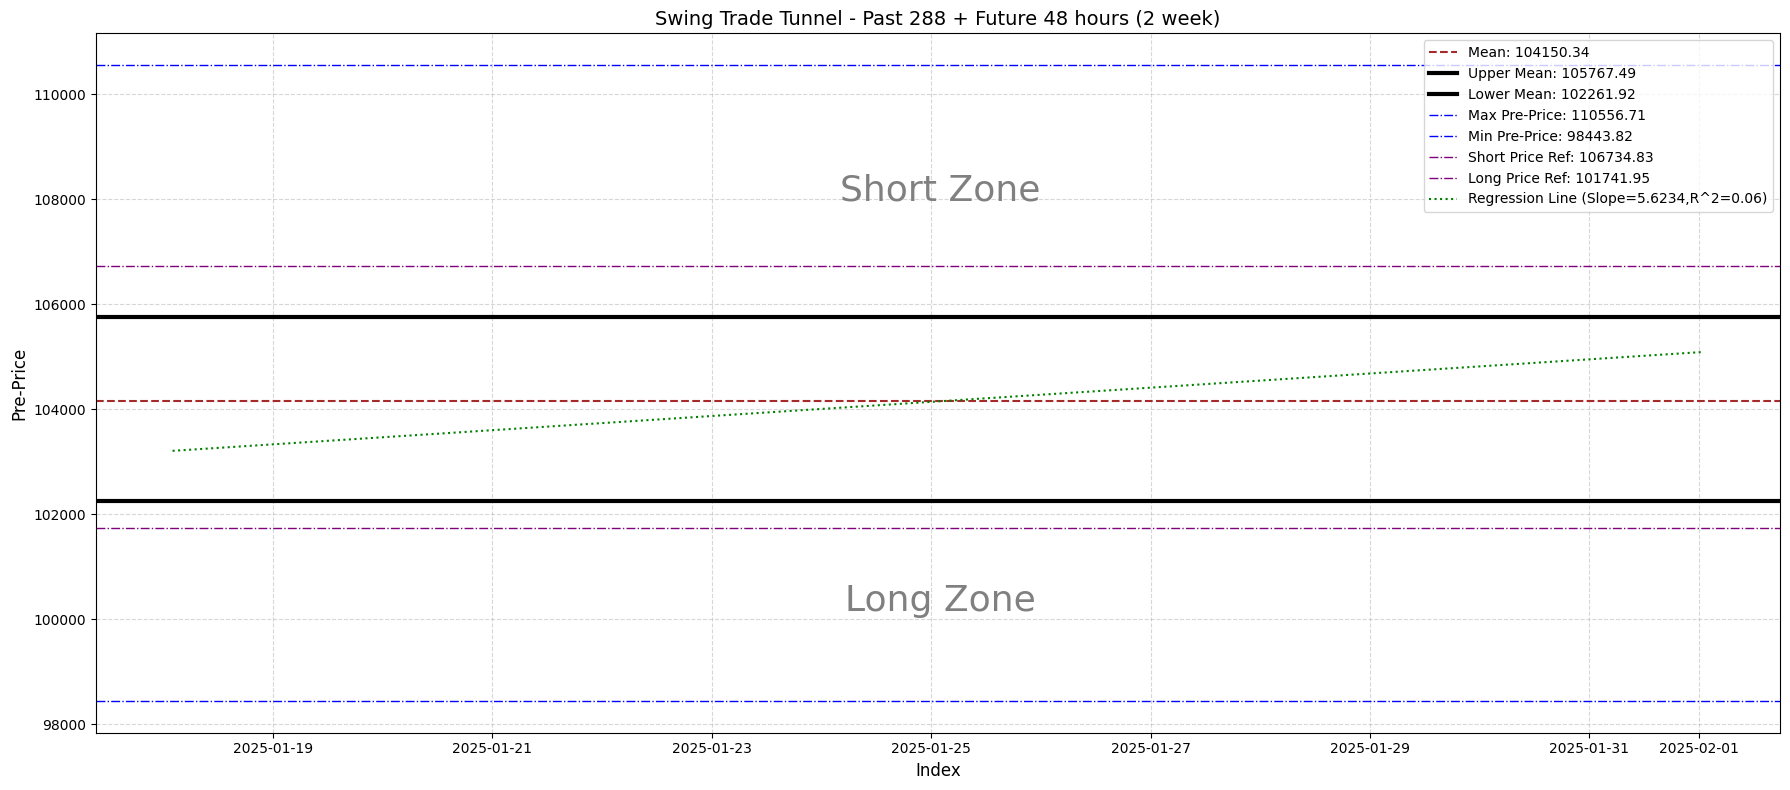

In [ ]:
x = tunnel['Predicted_Time']
y = tunnel['Pre-Price']

#@title Swing Trade Tunnel - Past 288 + Future 48 hours (2 week)"
# Calculate max and min Pre-Price

max_pre_price = tunnel["Pre-Price"].max()
min_pre_price = tunnel["Pre-Price"].min()


mean_pre_price = tunnel["Pre-Price"].mean()
upper_mean_pre_price = tunnel.loc[tunnel["Pre-Price"] > mean_pre_price, "Pre-Price"].mean()
lower_mean_pre_price = tunnel.loc[tunnel["Pre-Price"] < mean_pre_price, "Pre-Price"].mean()


mean_upper_mae_price = tunnel['Upper_MAE_Price'].mean()
upper_upper_mean_pre_price = tunnel.loc[tunnel["Upper_MAE_Price"] > mean_pre_price, "Upper_MAE_Price"].mean()

mean_lower_mae_price = tunnel['Lower_MAE_Price'].mean()
lower_lower_mean_pre_price = tunnel.loc[tunnel["Lower_MAE_Price"] < mean_pre_price, "Lower_MAE_Price"].mean()

# Calculate regression line
x = range(len(tunnel))
slope, intercept, r_value, _, _ = linregress(x, tunnel["Pre-Price"])
regression_line = [slope * i + intercept for i in x]
r_squared = r_value ** 2
# Plotting
plt.figure(figsize=(18, 8))


# Plot mean, upper mean, and lower mean
plt.axhline(mean_pre_price, color="brown", linestyle="--", linewidth=1.5, label=f"Mean: {mean_pre_price:.2f}")
plt.axhline(upper_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Upper Mean: {upper_mean_pre_price:.2f}")
plt.axhline(lower_mean_pre_price, color="black", linestyle="-", linewidth=3, label=f"Lower Mean: {lower_mean_pre_price:.2f}")
plt.axhline(max_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Max Pre-Price: {max_pre_price:.2f}")
plt.axhline(min_pre_price, color="blue", linestyle="-.", linewidth=1, label=f"Min Pre-Price: {min_pre_price:.2f}")

plt.axhline(upper_upper_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Short Price Ref: {upper_upper_mean_pre_price :.2f}")
plt.axhline(lower_lower_mean_pre_price , color="Purple", linestyle="-.", linewidth=1., label=f"Long Price Ref: {lower_lower_mean_pre_price :.2f}")

# Plot regression line
plt.plot(tunnel.index, regression_line, color="green", linestyle=":", linewidth=1.5, label=f"Regression Line (Slope={slope:.4f},R^2={r_squared:.2f})")


# Add annotations for zones in grey color
plt.text(tunnel.index[len(tunnel)//2], (max_pre_price + upper_mean_pre_price) / 2, "Short Zone", fontsize=26, color="grey",
         ha="center", va="center")
plt.text(tunnel.index[len(tunnel)//2], (min_pre_price + lower_mean_pre_price) / 2, "Long Zone", fontsize=26, color="grey",
         ha="center", va="center")

# Add title and labels
plt.title("Swing Trade Tunnel - Past 288 + Future 48 hours (2 week)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Pre-Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.tight_layout()
plt.savefig('Swing Trade Tunnel.jpg', format='jpg')
plt.show()

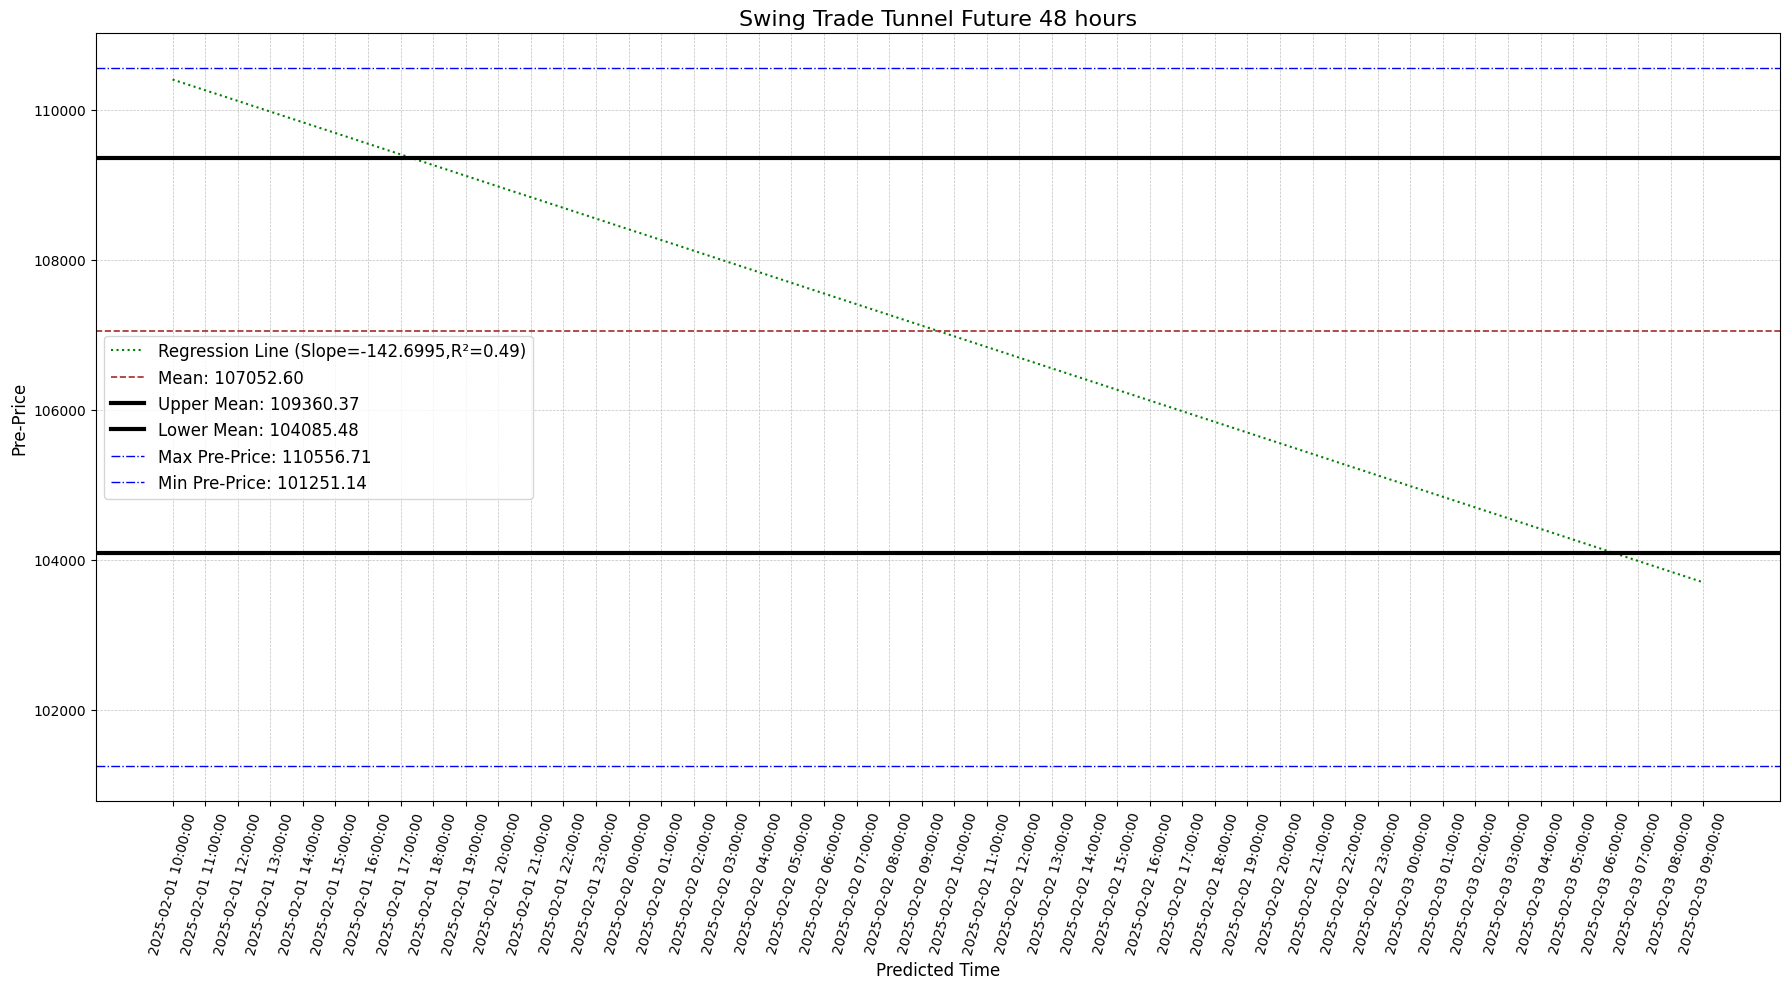

In [ ]:
#@title 48 Hour Prediction Code


#mae = 0.81

#ft_48hr['Upper_MAE_Price'] = ft_48hr['Close'] * (1 + result['Upper_MAE'] / 100)
#ft_48hr['Lower_MAE_Price'] = ft_48hr['Close'] * (1 + result['Lower_MAE'] / 100)



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming ft_48hr is your DataFrame
x = ft_48hr['Predicted_Time']
y = ft_48hr['Pre-Price']

# Middle time
middle_row = len(ft_48hr) // 2
middle_time = ft_48hr['Predicted_Time'].iloc[middle_row]

# Find the peak, dip, and mean values
peak_value_48hr = ft_48hr['Pre-Price'].max()
dip_value_48hr = ft_48hr['Pre-Price'].min()
mean_value_48hr = ft_48hr['Pre-Price'].mean()

# Compute the upper mean (values greater than the overall mean)
upper_mean_value_48hr = ft_48hr.loc[ft_48hr['Pre-Price'] > mean_value_48hr, 'Pre-Price'].mean()
# Compute the lower mean (values less than the overall mean)
lower_mean_value_48hr = ft_48hr.loc[ft_48hr['Pre-Price'] < mean_value_48hr, 'Pre-Price'].mean()

# Convert 'x' to numerical values if it's time
x_numeric = np.arange(len(x))  # Replace with logic if needed

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_numeric, y)

# Calculate regression line
regression_line = slope * x_numeric + intercept

# Plot the data
plt.figure(figsize=(18, 10))
# Plot the regression line
plt.plot(x, regression_line, color='green', linestyle=':', linewidth=1.5,label=f'Regression Line (Slope={slope:.4f},R²={r_value**2:.2f})')


plt.axhline(mean_value_48hr, color='brown', linestyle='--', linewidth=1.2, label=f'Mean: {mean_value_48hr:.2f}')
plt.axhline(upper_mean_value_48hr, color='black', linestyle='-', linewidth=3, label=f'Upper Mean: {upper_mean_value_48hr:.2f}')
plt.axhline(lower_mean_value_48hr, color='black', linestyle='-', linewidth=3, label=f'Lower Mean: {lower_mean_value_48hr:.2f}')
plt.axhline(peak_value_48hr, color="blue", linestyle="-.", linewidth=1, label=f"Max Pre-Price: {peak_value_48hr:.2f}")
plt.axhline(dip_value_48hr, color="blue", linestyle="-.", linewidth=1, label=f"Min Pre-Price: {dip_value_48hr:.2f}")


# Add annotations for zones in grey color
#plt.text(ft_48hr.index[len(ft_48hr)//2], (peak_value_48hr + upper_mean_value_48hr) / 2, "Short Zone", fontsize=26, color="grey",
 #        ha="center", va="center")
#plt.text(ft_48hr.index[len(ft_48hr)//2], (dip_value_48hr + lower_mean_value_48hr) / 2, "Long Zone", fontsize=26, color="grey",
 #        ha="center", va="center")


# Add labels and title
plt.title("Swing Trade Tunnel Future 48 hours", fontsize=16)
plt.xlabel("Predicted Time", fontsize=12)
plt.ylabel("Pre-Price", fontsize=12)
plt.xticks(rotation=75)
plt.legend(fontsize=12)
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.8)

# Display the plot
plt.tight_layout()
plt.savefig('Swing Trade Tunnel Future 48hr.jpg', format='jpg')
plt.show()

In [ ]:
# Calculate percentage differences
# 計算 Peak 至 Dip 的下降百分比
peak_to_dip_percentage = ((peak_value_48hr - mean_value_48hr) / peak_value_48hr) * 100

# 計算 Dip 至 Peak 的上升百分比
dip_to_peak_percentage = ((peak_value_48hr - mean_value_48hr) / dip_value_48hr) * 100

<ipython-input-35-b4d11182aa10>:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f"{txt:.2f}", (x[i], y[i]),


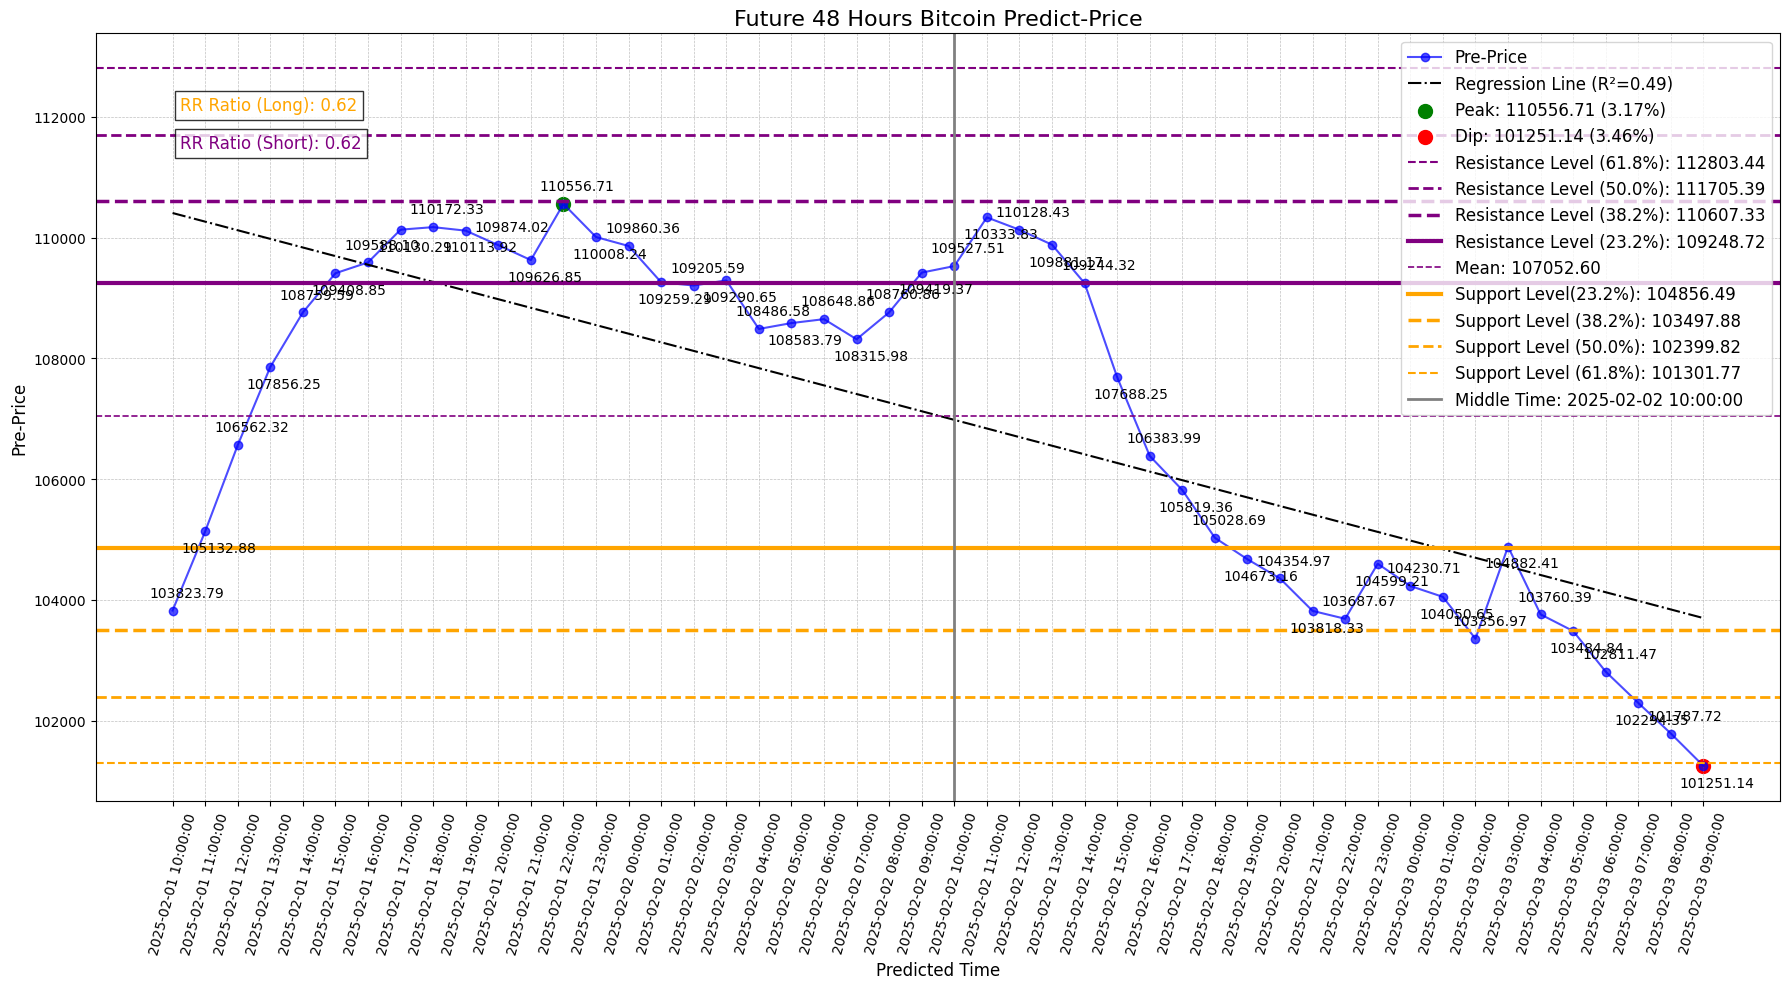

In [ ]:
#@title 48 Hour Prediction Code

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


# 計算 Long（向上趨勢）止蝕價
fib_618_long_stop_loss = mean_value_48hr - (peak_value_48hr - dip_value_48hr) * 0.618

# 計算 Short（向下趨勢）止蝕價
fib_618_short_stop_loss = mean_value_48hr + (peak_value_48hr - dip_value_48hr) * 0.618

# 計算 Long 和 Short 的 RR Ratio
entry_price_long = mean_value_48hr - (peak_value_48hr - dip_value_48hr) * 0.236
support_2 = mean_value_48hr - (peak_value_48hr - dip_value_48hr) * 0.382
support_3 = mean_value_48hr - (peak_value_48hr - dip_value_48hr) * 0.5

take_profit_price_long = mean_value_48hr
potential_reward_long = abs(take_profit_price_long - entry_price_long)
potential_risk_long = abs(entry_price_long - fib_618_long_stop_loss)
rr_ratio_long = potential_reward_long / potential_risk_long

entry_price_short = mean_value_48hr + (peak_value_48hr - dip_value_48hr) * 0.236
resistance_2 = mean_value_48hr + (peak_value_48hr - dip_value_48hr) * 0.382
resistance_3 = mean_value_48hr + (peak_value_48hr - dip_value_48hr) * 0.5

take_profit_price_short = mean_value_48hr
potential_reward_short = abs(entry_price_short - take_profit_price_short)
potential_risk_short = abs(entry_price_short - fib_618_short_stop_loss)
rr_ratio_short = potential_reward_short / potential_risk_short


# Assuming ft_48hr is your DataFrame
x = ft_48hr['Predicted_Time']
y = ft_48hr['Pre-Price']

# Middle time
middle_row = len(ft_48hr) // 2
middle_time = ft_48hr['Predicted_Time'].iloc[middle_row]

# Find the peak, dip, and mean values
peak_value_48hr = ft_48hr['Pre-Price'].max()
dip_value_48hr = ft_48hr['Pre-Price'].min()
mean_value_48hr = ft_48hr['Pre-Price'].mean()

# Compute the upper mean (values greater than the overall mean)
upper_mean_value_48hr = ft_48hr.loc[ft_48hr['Pre-Price'] > mean_value_48hr, 'Pre-Price'].mean()
# Compute the lower mean (values less than the overall mean)
lower_mean_value_48hr = ft_48hr.loc[ft_48hr['Pre-Price'] < mean_value_48hr, 'Pre-Price'].mean()

# Get corresponding times for peak and dip
peak_time_48hr = ft_48hr.loc[ft_48hr['Pre-Price'].idxmax(), 'Predicted_Time']
dip_time_48hr = ft_48hr.loc[ft_48hr['Pre-Price'].idxmin(), 'Predicted_Time']

# Convert 'x' to numerical values if it's time
x_numeric = np.arange(len(x))  # Replace with logic if needed

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_numeric, y)

# Calculate regression line
regression_line = slope * x_numeric + intercept

# Plot the data
plt.figure(figsize=(18, 10))
plt.plot(x, y, marker='o', label='Pre-Price', color='blue', alpha=0.7)

# Plot the regression line
plt.plot(x, regression_line, color='black', linestyle='-.', label=f'Regression Line (R²={r_value**2:.2f})')
# Highlight the peak and dip points
plt.scatter(peak_time_48hr, peak_value_48hr, color='green', label=f'Peak: {peak_value_48hr:.2f} ({peak_to_dip_percentage:.2f}%)', s=100)
plt.scatter(dip_time_48hr, dip_value_48hr, color='red', label=f'Dip: {dip_value_48hr:.2f} ({dip_to_peak_percentage:.2f}%)', s=100)


# Add Short (向下) Stop-Loss Line (161.8%)
plt.axhline(fib_618_short_stop_loss, linestyle='--', color='purple', linewidth=1.5,
            label=f'Resistance Level (61.8%): {fib_618_short_stop_loss:.2f}')

plt.axhline(resistance_3, linestyle='--', color='purple', linewidth=2,
            label=f'Resistance Level (50.0%): {resistance_3:.2f}')

plt.axhline(resistance_2, linestyle='--', color='purple', linewidth=2.5,
            label=f'Resistance Level (38.2%): {resistance_2:.2f}')


plt.axhline(entry_price_short, linestyle='-', color='purple', linewidth=3,
            label=f'Resistance Level (23.2%): {entry_price_short:.2f}')


plt.axhline(mean_value_48hr, color='purple', linestyle='--', linewidth=1.2, label=f'Mean: {mean_value_48hr:.2f}')

plt.axhline(entry_price_long , linestyle='-', color='orange', linewidth=3,
            label=f'Support Level(23.2%): {entry_price_long:.2f}')

plt.axhline(support_2, linestyle='--', color='orange', linewidth=2.5,
            label=f'Support Level (38.2%): {support_2:.2f}')

plt.axhline(support_3, linestyle='--', color='orange', linewidth=2,
            label=f'Support Level (50.0%): {support_3:.2f}')

# Add Long (向上) Stop-Loss Line (161.8%)
plt.axhline(fib_618_long_stop_loss, linestyle='--', color='orange', linewidth=1.5,
            label=f'Support Level (61.8%): {fib_618_long_stop_loss:.2f}')





# Annotate each point with staggered positions
for i, txt in enumerate(y):
    offset = 10 if i % 2 == 0 else -15  # Stagger position to avoid overlap
    plt.annotate(f"{txt:.2f}", (x[i], y[i]),
                 textcoords="offset points", xytext=(10, offset),
                 ha='center', fontsize=10, rotation=0)

# Add a vertical line at the middle time
plt.axvline(x=middle_time, color='grey', linestyle='-', linewidth=2, label=f'Middle Time: {middle_time}')

# 添加 RR Ratio 作為圖表文本
plt.text(0.05, 0.9, f"RR Ratio (Long): {rr_ratio_long:.2f}", transform=plt.gca().transAxes,
         fontsize=12, color='orange', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.05, 0.85, f"RR Ratio (Short): {rr_ratio_short:.2f}", transform=plt.gca().transAxes,
         fontsize=12, color='purple', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.title("Future 48 Hours Bitcoin Predict-Price", fontsize=16)
plt.xlabel("Predicted Time", fontsize=12)
plt.ylabel("Pre-Price", fontsize=12)
plt.xticks(rotation=75)
plt.legend(fontsize=12)
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.8)

# Display the plot
plt.tight_layout()
plt.savefig('Let be a Film Investor.jpg', format='jpg')
plt.show()

In [ ]:
#@title Peformance Plot Code
# Ensure both 'HKT' columns are in datetime format
df4['HKT'] = pd.to_datetime(df4['HKT'])
ft_result['HKT'] = pd.to_datetime(ft_result['HKT'])

# Merge the two DataFrames on the 'HKT' column
ft_merged_df = pd.merge(
    df4[['HKT', 'Close']],  # Select only HKT and Close columns
    ft_result[['HKT', 'Predicted_Time', 'MAE-Price', 'Pre-Price']],  # Select required columns
    on='HKT'  # Merge on the 'HKT' column
)

# Set 'HKT' as the index
ft_merged_df.set_index('HKT', inplace=True)

# Display the merged DataFrame
#merged_df

ft_merged_df
ft_merged_df['Shifted Predict Price'] = ft_merged_df['Pre-Price'].shift(+48)
ft_grap4 = ft_merged_df.iloc[-336:]
ft_grap5 = ft_merged_df.iloc[-48:]
ft_grap6 = ft_merged_df.iloc[-96:]

ft_merged_df.to_csv("/content/drive/MyDrive/Colab Notebooks/BTC/241217/ft_merged_df.csv", index=False)

<ipython-input-36-28a61caaba98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['HKT'] = pd.to_datetime(df4['HKT'])


### 這兩個圖表是比較現實Bitcoin Price 同預測的Bitcoin Price 差異，雖然看上去很好，很接近，但因為Fine Tune Model 是實時（每Hour）Update，所以理論上很準確，它會不斷推返之前的推測。但我們不能以此作預測，但可作為參考，確認model沒有失效。因此，我們的買入賣出，要以mean 或min 或max 作決定，是想將誤差抵消。

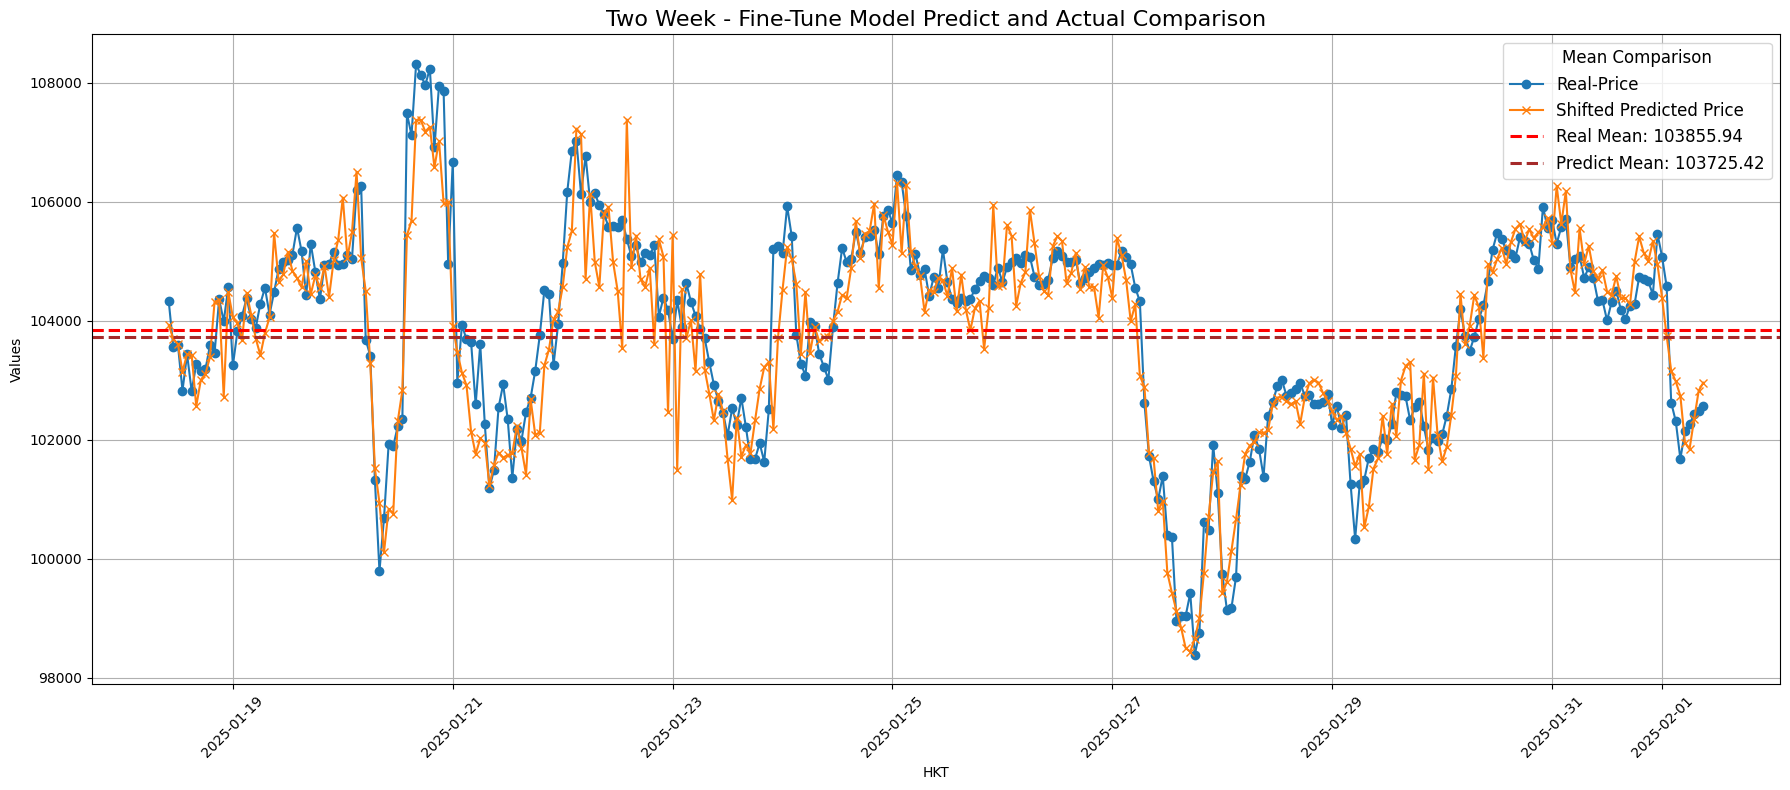

Close - Max Value: 108320.00999999998, Time: 2025-01-20 16:00:00
Close - Min Value: 98392.74000000002, Time: 2025-01-27 18:00:00
Pre-Price - Max Value: 107384.3901006579, Time: 2025-01-22 14:00:00
Pre-Price - Min Value: 98443.8237972659, Time: 2025-01-27 17:00:00
Mean Close: 103855.94342714518
Mean Pre-Price: 103725.41792165255
Range between Real and Predict: 130.52550549262378
Correlation: 0.92


In [ ]:
#@title Model Performance Plot (Fine-Tune Model) Code
import matplotlib.pyplot as plt

# Find max and min values for Close
max_close_value = ft_grap4["Close"].max()
max_close_time = ft_grap4["Close"].idxmax()

min_close_value = ft_grap4["Close"].min()
min_close_time = ft_grap4["Close"].idxmin()

# Find max and min values for Shifted Predict Price
max_mae_value = ft_grap4['Shifted Predict Price'].max()
max_mae_time = ft_grap4['Shifted Predict Price'].idxmax()

min_mae_value = ft_grap4['Shifted Predict Price'].min()
min_mae_time = ft_grap4['Shifted Predict Price'].idxmin()

# Range between Real and Predicted
mean_close = ft_grap4['Close'].mean()
mean_mae = ft_grap4['Shifted Predict Price'].mean()
range_mean = mean_close - mean_mae

# Calculate correlation
correlation = ft_grap4["Close"].corr(ft_grap4['Shifted Predict Price'])

# Plot the comparison graph
plt.figure(figsize=(18, 8))
plt.plot(ft_grap4.index, ft_grap4['Close'], label="Real-Price", marker='o')
plt.plot(ft_grap4.index, ft_grap4['Shifted Predict Price'], label="Shifted Predicted Price", marker='x')

# Add horizontal lines for mean values
plt.axhline(mean_close, color='red', linestyle='--', linewidth=2.2, label=f'Real Mean: {mean_close:.2f}')
plt.axhline(mean_mae, color='brown', linestyle='--', linewidth=2.2, label=f'Predict Mean: {mean_mae:.2f}')

# Add title, labels, and grid
plt.title("Two Week - Fine-Tune Model Predict and Actual Comparison", fontsize=16)
plt.xlabel("HKT")
plt.ylabel("Values")
plt.legend(title='Mean Comparison', fontsize=12, title_fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Print the results
print(f"Close - Max Value: {max_close_value}, Time: {max_close_time}")
print(f"Close - Min Value: {min_close_value}, Time: {min_close_time}")
print(f"Pre-Price - Max Value: {max_mae_value}, Time: {max_mae_time}")
print(f"Pre-Price - Min Value: {min_mae_value}, Time: {min_mae_time}")
print(f"Mean Close: {mean_close}")
print(f"Mean Pre-Price: {mean_mae}")
print(f"Range between Real and Predict: {range_mean}")
print(f"Correlation: {correlation:.2f}")

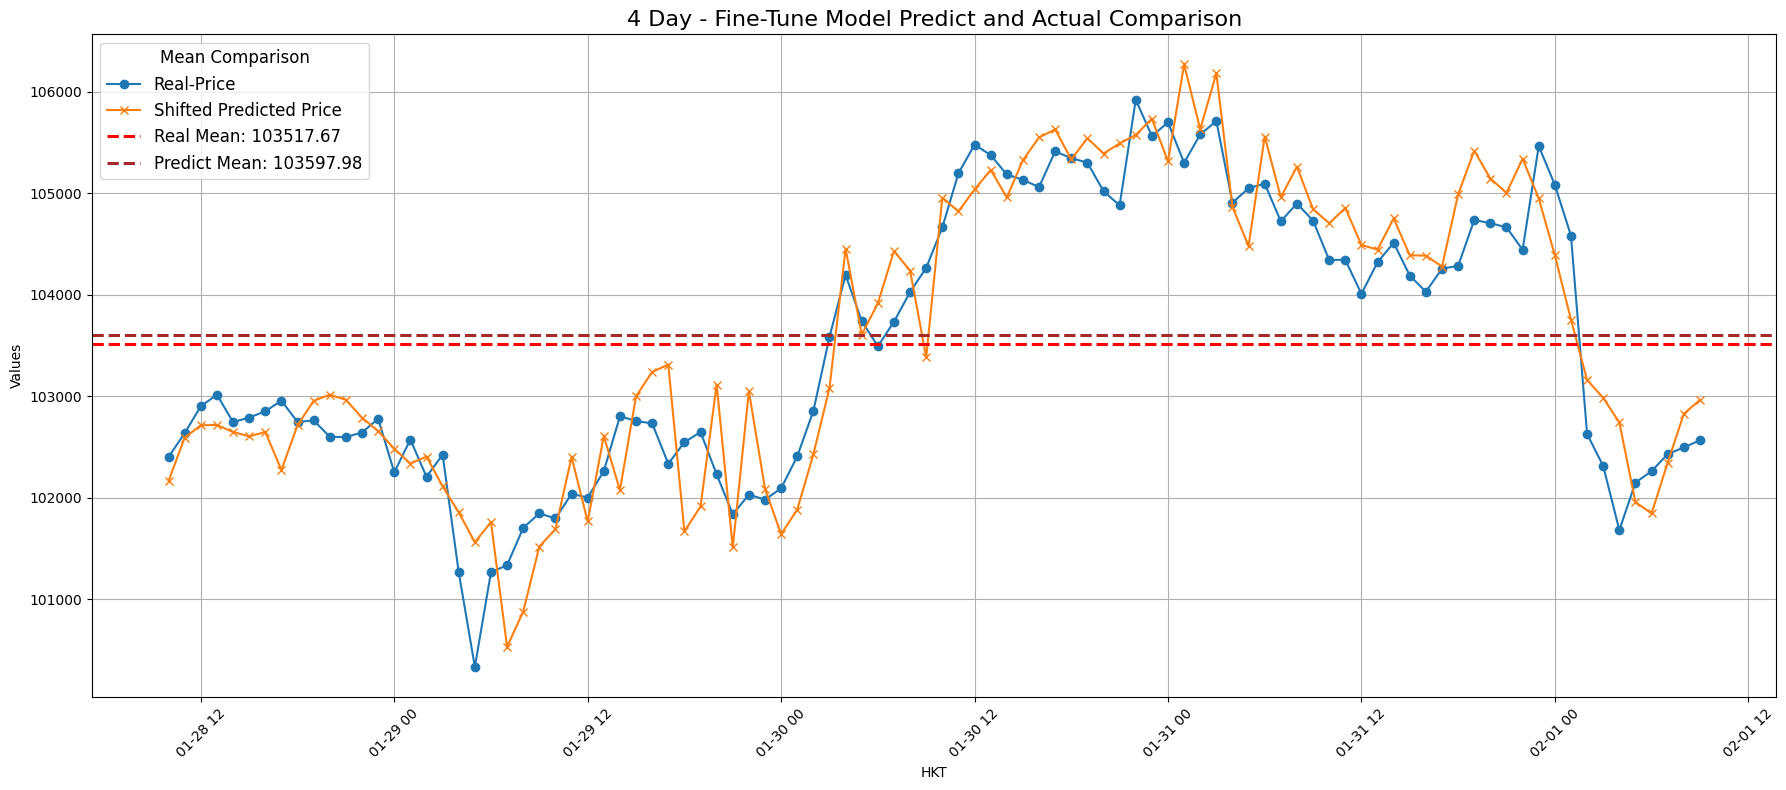

Close - Max Value: 105920.57, Time: 2025-01-30 22:00:00
Close - Min Value: 100334.01, Time: 2025-01-29 05:00:00
Pre-Price - Max Value: 106268.52425301075, Time: 2025-01-31 01:00:00
Pre-Price - Min Value: 100530.65752029423, Time: 2025-01-29 07:00:00
Mean Close: 103517.67064084146
Mean Pre-Price: 103597.97954587506
Range between Real and Predict: -80.30890503359842
Correlation: 0.94


In [ ]:
#@title Model Performance Plot (Fine-Tune Model) Code 4 day
# Find max and min values for Close
max_close_value = ft_grap6["Close"].max()
max_close_time = ft_grap6["Close"].idxmax()

min_close_value = ft_grap6["Close"].min()
min_close_time = ft_grap6["Close"].idxmin()

# Find max and min values for Shifted Predict Price
max_mae_value = ft_grap6['Shifted Predict Price'].max()
max_mae_time = ft_grap6['Shifted Predict Price'].idxmax()

min_mae_value = ft_grap6['Shifted Predict Price'].min()
min_mae_time = ft_grap6['Shifted Predict Price'].idxmin()

# Range between Real and Predicted
mean_close = ft_grap6['Close'].mean()
mean_mae = ft_grap6['Shifted Predict Price'].mean()
range_mean = mean_close - mean_mae

# Calculate correlation
correlation = ft_grap6["Close"].corr(ft_grap6['Shifted Predict Price'])

# Plot the comparison graph
plt.figure(figsize=(18, 8))
plt.plot(ft_grap6.index, ft_grap6['Close'], label="Real-Price", marker='o')
plt.plot(ft_grap6.index, ft_grap6['Shifted Predict Price'], label="Shifted Predicted Price", marker='x')

# Add horizontal lines for mean values
plt.axhline(mean_close, color='red', linestyle='--', linewidth=2.2, label=f'Real Mean: {mean_close:.2f}')
plt.axhline(mean_mae, color='brown', linestyle='--', linewidth=2.2, label=f'Predict Mean: {mean_mae:.2f}')

# Add title, labels, and grid
plt.title("4 Day - Fine-Tune Model Predict and Actual Comparison", fontsize=16)
plt.xlabel("HKT")
plt.ylabel("Values")
plt.legend(title='Mean Comparison', fontsize=12, title_fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Print the results
print(f"Close - Max Value: {max_close_value}, Time: {max_close_time}")
print(f"Close - Min Value: {min_close_value}, Time: {min_close_time}")
print(f"Pre-Price - Max Value: {max_mae_value}, Time: {max_mae_time}")
print(f"Pre-Price - Min Value: {min_mae_value}, Time: {min_mae_time}")
print(f"Mean Close: {mean_close}")
print(f"Mean Pre-Price: {mean_mae}")
print(f"Range between Real and Predict: {range_mean}")
print(f"Correlation: {correlation:.2f}")

In [ ]:
#@title Data Transformation for Ploting
# Define the new column order
new_column_order = ['HKT', 'Predicted_Time', 'Predicted']

# Reorder the DataFrame columns
predicted_df = predicted_df[new_column_order]

# Round the Predicted column to 3 decimal places
predicted_df['Predicted'] = predicted_df['Predicted'].round(3)

# Display the DataFrame with the rearranged columns
# Combine the DataFrames using the index
result = pd.concat([df4[['Close']], predicted_df], axis=1)

#@title Result Data Transformation 3
mae_value = 0.81

# Add a new column 'MAE'
result['MAE'] = result['Predicted'].apply(lambda x: x - mae_value if x > 0 else x + mae_value)

# Define the ME value
me_value = 0.09

# Add a new column 'ME' with the condition
result['ME'] = result['Predicted'].apply(lambda x: x - me_value if x > 0 else x + me_value)

result['Pre-Price'] = result['Close'] * (1 + result['Predicted'] / 100)
result['MAE-Price'] = result['Close'] * (1 + result['MAE'] / 100)
result['ME-Price'] = result['Close'] * (1 + result['ME'] / 100)
result = result.dropna()

# Ensure both 'HKT' columns are in datetime format
df4['HKT'] = pd.to_datetime(df4['HKT'])
result['HKT'] = pd.to_datetime(result['HKT'])

# Merge the two DataFrames on the 'HKT' column
merged_df = pd.merge(
    df4[['HKT', 'Close']],  # Select only HKT and Close columns
    result[['HKT', 'Predicted_Time', 'MAE-Price', 'Pre-Price']],  # Select required columns
    on='HKT'  # Merge on the 'HKT' column
)

# Set 'HKT' as the index
merged_df.set_index('HKT', inplace=True)

merged_df
merged_df['Shifted Predict Price'] = merged_df['Pre-Price'].shift(+48)
grap4 = merged_df.iloc[-336:]
grap_1week = merged_df.iloc[-168:]

<ipython-input-39-6520f601b5b4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['HKT'] = pd.to_datetime(df4['HKT'])


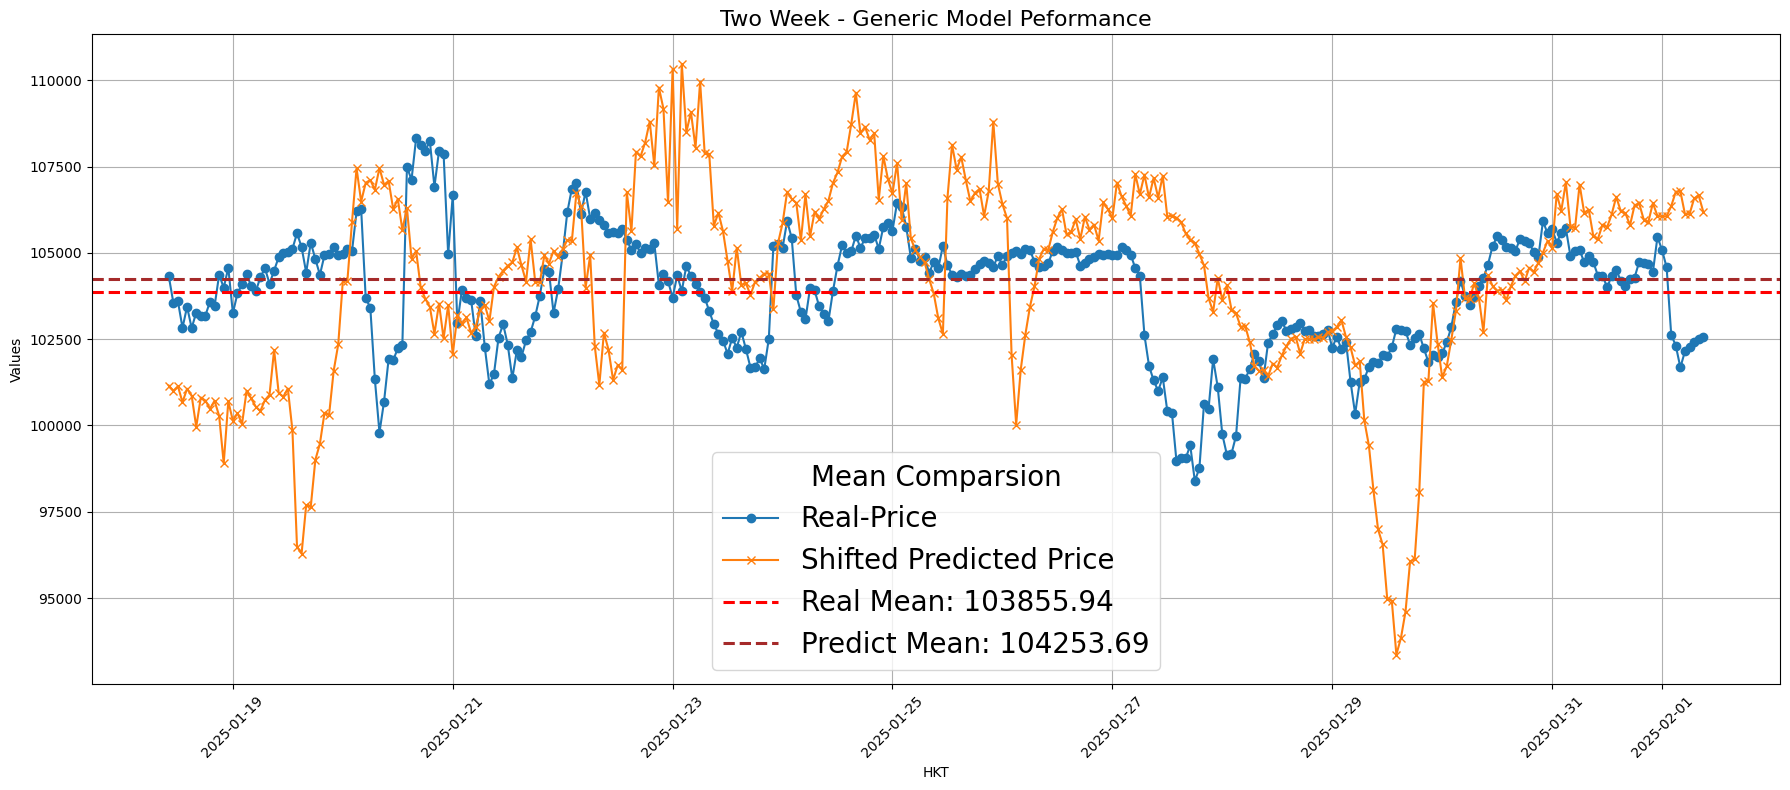

Close - Max Value: 108320.00999999998, Time: 2025-01-20 16:00:00
Close - Min Value: 98392.74000000002, Time: 2025-01-27 18:00:00
Pre-Price - Max Value: 110476.20637756829, Time: 2025-01-23 02:00:00
Pre-Price - Min Value: 93360.33753707887, Time: 2025-01-29 14:00:00
Mean Close: 103855.94342714518
Mean Pre-Price: 104253.69015421036
Range between Real and Predict: -397.7467270651832
Correlation:  0.16


In [ ]:

#@title Generic Model Performance Plot Code
max_close_value = grap4["Close"].max()
max_close_time = grap4["Close"].idxmax()

min_close_value = grap4["Close"].min()
min_close_time = grap4["Close"].idxmin()

# Find the maximum and minimum for MAE-Price
max_pre_value = grap4['Shifted Predict Price'].max()
max_pre_time = grap4['Shifted Predict Price'].idxmax()

min_pre_value = grap4['Shifted Predict Price'].min()
min_pre_time = grap4['Shifted Predict Price'].idxmin()

# Range between Real and Predict
mean_close = grap4['Close'].mean()
mean_pre = grap4['Shifted Predict Price'].mean()
range_mean = mean_close - mean_pre

# Calculate correlation
correlation = grap4["Close"].corr(grap4['Shifted Predict Price'])


plt.figure(figsize=(18, 8))
plt.plot(grap4.index, grap4['Close'], label="Real-Price", marker='o')
plt.plot(grap4.index, grap4['Shifted Predict Price'], label="Shifted Predicted Price", marker='x')


# Add a horizontal line for the Range mean value
plt.axhline(mean_close, color='red', linestyle='--', linewidth=2.2, label=f'Real Mean: {mean_close:.2f}')
plt.axhline(mean_pre, color='brown', linestyle='--', linewidth=2.2, label=f'Predict Mean: {mean_pre:.2f}')

plt.title("Two Week - Generic Model Peformance", fontsize=16)
plt.xlabel("HKT")
plt.ylabel("Values")
plt.legend(title='Mean Comparsion', fontsize=20, title_fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Print the results
print(f"Close - Max Value: {max_close_value}, Time: {max_close_time}")
print(f"Close - Min Value: {min_close_value}, Time: {min_close_time}")
print(f"Pre-Price - Max Value: {max_pre_value}, Time: {max_pre_time}")
print(f"Pre-Price - Min Value: {min_pre_value}, Time: {min_pre_time}")
print(f"Mean Close: {mean_close}")
print(f"Mean Pre-Price: {mean_pre}")
print(f"Range between Real and Predict: {range_mean}")
print(f"Correlation:  {correlation:.2f}")

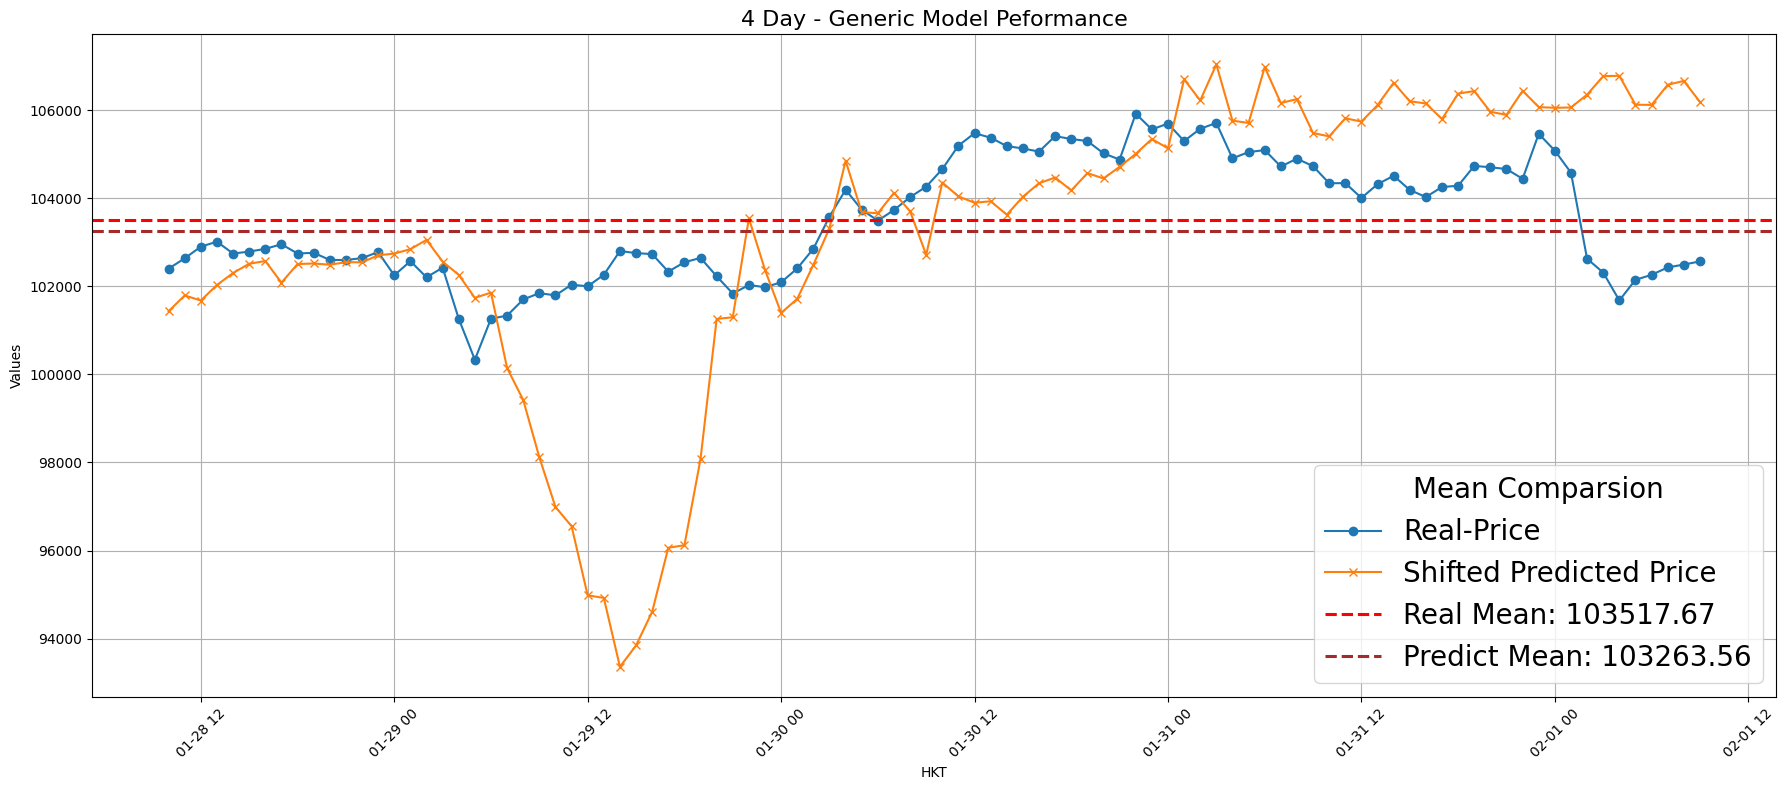

Close - Max Value: 105920.57, Time: 2025-01-30 22:00:00
Close - Min Value: 100334.01, Time: 2025-01-29 05:00:00
Pre-Price - Max Value: 107039.48020455362, Time: 2025-01-31 03:00:00
Pre-Price - Min Value: 93360.33753707887, Time: 2025-01-29 14:00:00
Mean Close: 103517.67064084146
Mean Pre-Price: 103263.56338087254
Range between Real and Predict: 254.10725996892143
Correlation:  0.55


In [ ]:
grap7 = grap4.iloc[-96:]

#@title 4 Day Generic Model Performance Plot Code
max_close_value = grap7["Close"].max()
max_close_time = grap7["Close"].idxmax()

min_close_value = grap7["Close"].min()
min_close_time = grap7["Close"].idxmin()

# Find the maximum and minimum for MAE-Price
max_pre_value = grap7['Shifted Predict Price'].max()
max_pre_time = grap7['Shifted Predict Price'].idxmax()

min_pre_value = grap7['Shifted Predict Price'].min()
min_pre_time = grap7['Shifted Predict Price'].idxmin()

# Range between Real and Predict
mean_close = grap7['Close'].mean()
mean_pre = grap7['Shifted Predict Price'].mean()
range_mean = mean_close - mean_pre

# Calculate correlation
correlation = grap7["Close"].corr(grap7['Shifted Predict Price'])


plt.figure(figsize=(18, 8))
plt.plot(grap7.index, grap7['Close'], label="Real-Price", marker='o')
plt.plot(grap7.index, grap7['Shifted Predict Price'], label="Shifted Predicted Price", marker='x')


# Add a horizontal line for the Range mean value
plt.axhline(mean_close, color='red', linestyle='--', linewidth=2.2, label=f'Real Mean: {mean_close:.2f}')
plt.axhline(mean_pre, color='brown', linestyle='--', linewidth=2.2, label=f'Predict Mean: {mean_pre:.2f}')

plt.title("4 Day - Generic Model Peformance", fontsize=16)
plt.xlabel("HKT")
plt.ylabel("Values")
plt.legend(title='Mean Comparsion', fontsize=20, title_fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Print the results
print(f"Close - Max Value: {max_close_value}, Time: {max_close_time}")
print(f"Close - Min Value: {min_close_value}, Time: {min_close_time}")
print(f"Pre-Price - Max Value: {max_pre_value}, Time: {max_pre_time}")
print(f"Pre-Price - Min Value: {min_pre_value}, Time: {min_pre_time}")
print(f"Mean Close: {mean_close}")
print(f"Mean Pre-Price: {mean_pre}")
print(f"Range between Real and Predict: {range_mean}")
print(f"Correlation:  {correlation:.2f}")

In [ ]:
#@title TG Plot Notification Code
import requests

# Define your Telegram bot token and chat ID
bot_token = '7949698390:AAG9ZW9tk5BDXPUu1Z3im5UQSPLJR36711g'
chat_id = '215081792'

def send_photo(chat_id, photo_path):
    url = f'https://api.telegram.org/bot{bot_token}/sendPhoto'
    with open(photo_path, 'rb') as photo:
        files = {'photo': photo}
        data = {'chat_id': chat_id}
        response = requests.post(url, files=files, data=data)
    return response.json()

# Example usage: sending a JPG file
photo_path = "Trade_Signal_Trends_with_Annotations_in_Legend.jpg"
response = send_photo(chat_id, photo_path)

if response.get('ok'):
    print(f"Photo sent to chat ID: {chat_id}")
else:
    print("Failed to send photo:", response)

Photo sent to chat ID: 215081792


In [ ]:
#@title TG Short and Long Number
import pandas as pd
import requests

# Define your Telegram bot token and chat ID
bot_token = '7949698390:AAG9ZW9tk5BDXPUu1Z3im5UQSPLJR36711g'
chat_id = '215081792'

def send_message(chat_id, text):
    """
    Send a text message to a Telegram chat.

    Args:
        chat_id (str): The chat ID to send the message to.
        text (str): The message text.
    """
    url = f'https://api.telegram.org/bot{bot_token}/sendMessage'
    data = {'chat_id': chat_id, 'text': text}
    response = requests.post(url, data=data)
    return response.json()

def notify_trade_signals(dataframe):
    """
    Check the last 24 rows' Trade_Signal in the DataFrame and send a message
    with the counts of 'Long' and 'Short'.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing Trade_Signal data.
    """
    try:
        # Get the last 24 rows of the Trade_Signal column
        last_signals = dataframe["Trade_Signal"].tail(24)

        # Count occurrences of 'Long' and 'Short'
        long_count = (last_signals == "Long").sum()
        short_count = (last_signals == "Short").sum()

        # Prepare the message
        message = f"'250102 version : Long={long_count}, Short={short_count}"

        # Send the message to Telegram
        response = send_message(chat_id, message)
        if response.get('ok'):
            print("Notification sent:", message)
        else:
            print("Failed to send message:", response)
    except Exception as e:
        print(f"Error occurred: {e}")

# Call the function to send the notification
notify_trade_signals(ft_result)

Notification sent: '250102 version : Long=3, Short=0


In [ ]:
#@title TG Plot Notification Code 2
import requests

# Define your Telegram bot token and chat ID
bot_token = '7949698390:AAG9ZW9tk5BDXPUu1Z3im5UQSPLJR36711g'
chat_id = '215081792'

def send_photo(chat_id, photo_path):
    url = f'https://api.telegram.org/bot{bot_token}/sendPhoto'
    with open(photo_path, 'rb') as photo:
        files = {'photo': photo}
        data = {'chat_id': chat_id}
        response = requests.post(url, files=files, data=data)
    return response.json()

# Example usage: sending a JPG file
photo_path = "Let be a Film Investor.jpg"
response = send_photo(chat_id, photo_path)

if response.get('ok'):
    print(f"Photo sent to chat ID: {chat_id}")
else:
    print("Failed to send photo:", response)

Photo sent to chat ID: 215081792


### 有關這個Swing Trade Tunnel 策略的思路分析和記錄


1.   買入和買出勿以Average Upper / Lower Mean 作參考，應以 Min Max 價格作入市位（當方向未確認時）
2.   所有隧道，都把預測48小時融入，是想找出最有參考價值的預測。
3.   因為暫時觀察，預測和實際價值的mean差距很少，雖然舊model有差2000點的距離，但那是Generic Model
4.   所以直至31/12都不可以交易，直至看Generic model 和 Fine Tune Model 的mean有幾大的差距。
5.   由於各Tunnel都是使用Fine Tune Model，換言之Fine Tune Model預測Bitcoin price 的mean 和 實際的mean 差距不大，即所有tunnel 都有參考價值，關鍵在於吸收了預測後，他的偏差有多少
6.   初步觀察，Long Period 呈Up trend，Short Period 呈down trend，Short Period 的Min會成為頂部
7.   留意R square每小時變化，所有Tunnel都在下降中@12/20 1200 ，或者可以是指標
8.   如果Generic model mean 的差距最終很大，不代表一定失效，關鍵是fine tune model
9.   Short Period 同 Long Period 相反 - Long Up Short Down - Buy @ Long Min and Sell @ Short Min ?
10.  沙盤推演Scenario 1）長短一致升 2）長短一致跌 3） 長升短跌 4） 長跌短升
11.  就算睇跌升，都可能要把slope作考慮因素
12.  New Upate @ 26/12 根據觀察一星期，確認只以moving Peak & Dip as Buy and Sell Price
13.  建議Set Price，可以選擇每晚2100-2400，待美國方面出方向。






